In [ ]:
import load_data
import numpy as np
import torch as th
import torch.nn as nn
import pandas as pd
import PIL
import matplotlib.pyplot as plt

# Helper Functions

In [3]:
def true_params(cases, recovered, deaths, population):
    X = cases
    R = recovered + deaths

    n = np.array([population] * len(X), dtype=np.float64)

    S = n - X - R

    X_diff = np.array([X[:-1], X[1:]], dtype=np.float64).T
    R_diff = np.array([R[:-1], R[1:]], dtype=np.float64).T


    gamma = (R[1:] - R[:-1]) / (X[:-1])
    beta = n[:-1] * (X[1:] - X[:-1] + R[1:] - R[:-1]) / (X[:-1] * (n[:-1] - X[:-1] - R[:-1]))
    return np.nan_to_num(gamma), np.nan_to_num(beta)

In [9]:
def nan_to_num(t,mynan=0.):
    if th.all(th.isfinite(t)):
        return t
    if len(t.size()) == 0:
        return th.tensor(mynan)
    return th.cat([nan_to_num(l).unsqueeze(0) for l in t],0)

In [10]:
def my_msle(output, target):
    loss = th.mean(((output.add(1)).log() - (target.add(1)).log())**2)
    return loss

# Load Data

In [1]:
df = load_data.load_county_level(data_dir='data')
keys = df.keys()

loading county-level data...
loaded and merged COVID-19 cases/deaths data successfully


In [2]:
attr_cols = []

# Set the variable to True if we want to specify features ourselves.
use_specified_fields = False

if use_specified_fields:
    f = open("fields.txt", "r")
    fields = f.readlines()
    for field in fields:
        field = field.rstrip()
        arr = np.array(df[field])
        if arr.dtype == np.float32 or arr.dtype == np.float64:
            attr_cols.append(np.array(arr, dtype=np.float32))
else:
    for i in range(6, 86):
        arr = np.array(df[keys[i]])
        if arr.dtype == np.float32 or arr.dtype == np.float64:
            attr_cols.append(np.array(arr, dtype=np.float32))

attrs = th.tensor(np.stack(attr_cols, 1), dtype=th.float32)
cases = []
# for i in range(87, 216):
for i in range(132, 216):
    cases.append(np.array(df[keys[i]]))
cases = np.stack(cases, 1)
deaths = []
# for i in range(218, 347):
for i in range(263, 347):
    deaths.append(np.array(df[keys[i]]))
deaths = np.stack(deaths, 1)

pop = attrs[:,5]
pop = pop.view(3142, 1)
pop[1834] = 96471 #fixed the population value for Erie

In [4]:
gamma_lst = []
beta_lst = []
recovered = np.zeros(len(cases[0]))
for i in range(len(cases)):
    gamma, beta = true_params(cases[i], recovered, deaths[i], pop[i])
    gamma_lst.append(gamma)
    beta_lst.append(beta)
gamma_lst = np.nan_to_num(np.stack(gamma_lst,0))
beta_lst = np.nan_to_num(np.stack(beta_lst,0))

/home/ubuntu/.local/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/home/ubuntu/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/home/ubuntu/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/home/ubuntu/.local/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


In [6]:
out_size = 1
num_days = cases.shape[1]
num_valid_days = 15
num_test_days = 15
train_valid_split = num_days - num_valid_days - num_test_days
valid_test_split = num_days - num_test_days
in_len = 20
out_len = 1

train_past_cases_1d = []
train_past_deaths_1d = []
train_past_gamma_1d = []
train_past_beta_1d = []
train_labels_cases_1d = []
train_labels_deaths_1d = []
train_labels_gamma_1d = []
train_labels_beta_1d = []

# for start in range(14):
#     end = start + in_len + out_len - 1
#     end_begin = end - out_len
#     train_past_cases_1d.append(th.tensor(cases[:,start:end_begin], dtype=th.float32))
#     train_past_deaths_1d.append(th.mul(th.tensor(deaths[:,start:end_begin], dtype=th.float32),1))
#     train_labels_cases_1d.append(th.tensor(cases[:,end_begin:end], dtype=th.float32))
#     train_labels_deaths_1d.append(th.mul(th.tensor(deaths[:,end_begin:end], dtype=th.float32),1))

# for start in range(14, train_valid_split - in_len - out_len + 1):
#     end = start + in_len + out_len - 1
#     end_begin = end - out_len
#     train_past_cases_1d.append(th.tensor(cases[:,start:end_begin], dtype=th.float32))
#     train_past_deaths_1d.append(th.mul(th.tensor(cases[:,start-14:end_begin-14], dtype=th.float32),1))
#     train_labels_cases_1d.append(th.tensor(cases[:,end_begin:end], dtype=th.float32))
#     train_labels_deaths_1d.append(th.mul(th.tensor(cases[:,end_begin-14:end-14], dtype=th.float32),1))

for start in range(train_valid_split - in_len - out_len + 1):
    end = start + in_len + out_len - 1
    end_begin = end - out_len
    train_past_cases_1d.append(th.tensor(cases[:,start:end_begin], dtype=th.float32))
    train_past_deaths_1d.append(th.tensor(deaths[:,start:end_begin], dtype=th.float32))
    train_past_gamma_1d.append(nan_to_num(th.tensor(gamma_lst[:,start:end_begin], dtype=th.float32),0))
    train_past_beta_1d.append(nan_to_num(th.tensor(beta_lst[:,start:end_begin], dtype=th.float32),0))
    train_labels_cases_1d.append(th.tensor(cases[:,end_begin:end], dtype=th.float32))
    train_labels_deaths_1d.append(th.tensor(deaths[:,end_begin:end], dtype=th.float32))
    train_labels_gamma_1d.append(nan_to_num(th.tensor(gamma_lst[:,end_begin:end], dtype=th.float32),0))
    train_labels_beta_1d.append(nan_to_num(th.tensor(beta_lst[:,end_begin:end], dtype=th.float32),0))


valid_past_cases_1d = []
valid_past_deaths_1d = []
valid_past_gamma_1d = []
valid_past_beta_1d = []
valid_labels_cases_1d = []
valid_labels_deaths_1d = []
valid_labels_gamma_1d = []
valid_labels_beta_1d = []
for start in range(train_valid_split - in_len - out_len + 1, valid_test_split - in_len - out_len):
    end = start + in_len + out_len - 1
    end_begin = end - out_len
    valid_past_cases_1d.append(th.tensor(cases[:,start:end_begin], dtype=th.float32))
    valid_past_deaths_1d.append(th.mul(th.tensor(deaths[:,start:end_begin], dtype=th.float32),1))
    valid_past_gamma_1d.append(nan_to_num(th.tensor(gamma_lst[:,start:end_begin], dtype=th.float32),0))
    valid_past_beta_1d.append(nan_to_num(th.tensor(beta_lst[:,start:end_begin], dtype=th.float32),0))
    valid_labels_cases_1d.append(th.tensor(cases[:,end_begin:end], dtype=th.float32))
    valid_labels_deaths_1d.append(th.mul(th.tensor(deaths[:,end_begin:end], dtype=th.float32),1))
    valid_labels_gamma_1d.append(nan_to_num(th.tensor(gamma_lst[:,end_begin:end], dtype=th.float32),0))
    valid_labels_beta_1d.append(nan_to_num(th.tensor(beta_lst[:,end_begin:end], dtype=th.float32),0))
    
test_past_cases_1d = []
test_past_deaths_1d = []
test_past_gamma_1d = []
test_past_beta_1d = []
test_labels_cases_1d = []
test_labels_deaths_1d = []
test_labels_gamma_1d = []
test_labels_beta_1d = []
for start in range(valid_test_split - in_len - out_len + 1, num_days - in_len - out_len):
    end = start + in_len + out_len - 1
    end_begin = end - out_len
    test_past_cases_1d.append(th.tensor(cases[:,start:end_begin], dtype=th.float32))
    test_past_deaths_1d.append(th.mul(th.tensor(deaths[:,start:end_begin], dtype=th.float32),1))
    test_past_gamma_1d.append(nan_to_num(th.tensor(gamma_lst[:,start:end_begin], dtype=th.float32),0))
    test_past_beta_1d.append(nan_to_num(th.tensor(beta_lst[:,start:end_begin], dtype=th.float32),0))
    test_labels_cases_1d.append(th.tensor(cases[:,end_begin:end], dtype=th.float32))
    test_labels_deaths_1d.append(th.mul(th.tensor(deaths[:,end_begin:end], dtype=th.float32),1))
    test_labels_gamma_1d.append(nan_to_num(th.tensor(gamma_lst[:,end_begin:end], dtype=th.float32),0))
    test_labels_beta_1d.append(nan_to_num(th.tensor(beta_lst[:,end_begin:end], dtype=th.float32),0))

In [7]:
train_labels_Sacramento = []
for i in range(34):
    train_labels_Sacramento.append(train_labels_cases_1d[i][202].cpu().numpy())

train_labels_NYC = []
for i in range(34):
    train_labels_NYC.append(train_labels_cases_1d[i][4].cpu().numpy())

# Models

## MLP - SIR

In [8]:
class Net_SIR(nn.Module):
    def __init__(self, input_size, hidden_size, out_size):
        super(Net_SIR, self).__init__()
        self.nn_model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            #nn.BatchNorm1d(num_features=hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, out_size),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.nn_model(x)

In [11]:
def my_msle_ID(I, D, I_label, D_label):
    I_loss = ((I.add(1)).log() - (I_label.add(1)).log())**2
    D_loss = ((D.add(1)).log() - (D_label.add(1)).log())**2
    loss = th.mean(th.add(I_loss, D_loss))
    return loss

In [12]:
def sir_1d_output(params, I, D):
    gamma = params[:,0]
    beta = params[:,1]
    I[I != I] = 0.0
    D[D != D] = 0.0
    err = th.tensor([0],dtype=th.float)
    err = err.to(device)
    S = pop - I - D

    I_new = th.add(th.add(I, th.mul(beta.view(3142,1), th.div(th.mul(S,I), pop))), - th.mul(gamma.view(3142,1), I))
    D_new = th.add(D, th.mul(gamma.view(3142,1), I))

    return I_new, D_new

## GAT - SIR

### Contiguous Graph

In [13]:
county_names = df['CountyName']
county_code = np.array([int(code) for code in df['countyFIPS']])
county_code_dict = {code:idx for idx, code in enumerate(county_code)}

In [14]:
data_contiguous = pd.read_csv('/home/ubuntu/covid19-severity-prediction/data/neighborcounties.csv')
df_contiguous = pd.DataFrame(data_contiguous, columns= ['orgfips','adjfips','instate'])

In [15]:
import dgl

g = dgl.DGLGraph()
g.add_nodes(len(county_code_dict))
for ind in df_contiguous.index: 
    src = int(df_contiguous['orgfips'][ind])
    dst = int(df_contiguous['adjfips'][ind])
    if src in county_code_dict and dst in county_code_dict:
        g.add_edge(county_code_dict[src],county_code_dict[dst])

Using backend: pytorch


In [16]:
from dgl.nn import pytorch as dglnn
import torch.nn.functional as F
import torch.nn as nn

class GAT_SIR(nn.Module):
    def __init__(self, g, input_size, hidden_size, output_size, gcn_nlayers, num_heads=5):
        super(GAT_SIR, self).__init__()
        self.g = g
        self.gcn_layers = nn.ModuleList()
        self.gcn_layers.append(dglnn.conv.GATConv(input_size, hidden_size, num_heads=num_heads,
                                                  residual=True, activation=F.relu))
        for i in range(gcn_nlayers):
            self.gcn_layers.append(dglnn.conv.GATConv(num_heads * hidden_size, hidden_size, num_heads=num_heads,
                                                      residual=True, activation=F.relu))

        self.linear_layers = nn.Sequential(
            nn.Linear(num_heads * hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        h = x
        for layer in self.gcn_layers:
            h = layer(self.g, h).flatten(1)
        return self.linear_layers(h)

# Training

## MLP - SIR (loss = cases label)

In [18]:
hidden_size = 100
learning_rate = 0.0000005
num_epochs = 1000
batch_size = 1000
output_size = 2

device = th.device('cuda:0')
input_size = train_past_cases_1d[0].shape[1] + attrs.shape[1]
mlp_sir = Net_SIR(input_size, hidden_size, output_size)
print('#features:', input_size)

# Move model to GPU
mlp_sir = mlp_sir.to(device)

# Move data to GPU
pop = pop.to(device)
attrs = attrs.to(device)
for i in range(len(train_past_cases_1d)):
    train_past_cases_1d[i] = train_past_cases_1d[i].to(device)
    train_past_deaths_1d[i] = train_past_deaths_1d[i].to(device)
    train_labels_cases_1d[i] = train_labels_cases_1d[i].to(device)
    train_labels_deaths_1d[i] = train_labels_deaths_1d[i].to(device)
    if len(train_labels_cases_1d[i].shape) == 1:
        train_labels_cases_1d[i] = train_labels_cases_1d[i].unsqueeze(1)
    if len(train_labels_deaths_1d[i].shape) == 1:
        train_labels_deaths_1d[i] = train_labels_deaths_1d[i].unsqueeze(1)
        
for i in range(len(valid_past_cases_1d)):
    valid_past_cases_1d[i] = valid_past_cases_1d[i].to(device)
    valid_past_deaths_1d[i] = valid_past_deaths_1d[i].to(device)
    valid_labels_cases_1d[i] = valid_labels_cases_1d[i].to(device)
    valid_labels_deaths_1d[i] = valid_labels_deaths_1d[i].to(device)
    if len(valid_labels_cases_1d[i].shape) == 1:
         valid_labels_cases_1d[i] = valid_labels_cases_1d[i].unsqueeze(1)
    if len(test_labels_deaths_1d[i].shape) == 1:
        valid_labels_deaths_1d[i] = valid_labels_deaths_1d[i].unsqueeze(1)

for i in range(len(test_past_cases_1d)):
    test_past_cases_1d[i] = test_past_cases_1d[i].to(device)
    test_past_deaths_1d[i] = test_past_deaths_1d[i].to(device)
    test_labels_cases_1d[i] = test_labels_cases_1d[i].to(device)
    test_labels_deaths_1d[i] = test_labels_deaths_1d[i].to(device)
    if len(test_labels_cases_1d[i].shape) == 1:
        test_labels_cases_1d[i] = test_labels_cases_1d[i].unsqueeze(1)
    if len(test_labels_deaths_1d[i].shape) == 1:
        test_labels_deaths_1d[i] = test_labels_deaths_1d[i].unsqueeze(1)
        
# Normalize attrs
attrs[th.isnan(attrs)] = 0
attr_mean = th.mean(attrs, dim=1, keepdim=True)
attrs = attrs - attr_mean
attr_std = th.std(attrs, dim=1, keepdim=True)
attrs = attrs / attr_std

new_eval_err = 1000
optimizer = th.optim.Adam(mlp_sir.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    losses = []
    for idx in range(len(train_past_cases_1d)):
        labels_cases = train_labels_cases_1d[idx]
        labels_deaths = train_labels_deaths_1d[idx]
        batch = th.cat([train_past_cases_1d[idx], attrs], dim=1)
        th.manual_seed(1)
        vals = mlp_sir(batch)
        I = train_past_cases_1d[idx][:,-1].view(3142,1)
        D = train_past_deaths_1d[idx][:,-1].view(3142,1)
        I_new, D_new = sir_1d_output(vals, I, D)
        loss = my_msle_ID(I_new, D_new, labels_cases, labels_deaths)
        loss.backward(retain_graph=True)
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
    
    count = 0
    with th.no_grad():
        eval_errs = []
        test_errs = []
        test_mses = []
        test_maes = []
        for idx in range(14):
            valid_feats = th.cat([valid_past_cases_1d[idx], attrs], dim=1)
            eval_vals = mlp_sir(valid_feats)
            eval_I = valid_past_cases_1d[idx][:,-1].view(3142,1)
            eval_D = valid_past_deaths_1d[idx][:,-1].view(3142,1)
            eval_labels_cases = valid_labels_cases_1d[idx]
            eval_labels_deaths = valid_labels_deaths_1d[idx]
            eval_I_new, eval_D_new = sir_1d_output(eval_vals, eval_I, eval_D)
            err = my_msle_ID(eval_I_new, eval_D_new, eval_labels_cases, eval_labels_deaths)
            eval_errs.append(err.cpu().numpy())
            
            test_feats = th.cat([test_past_cases_1d[idx], attrs], dim=1)
            test_vals = mlp_sir(test_feats)
            test_I = test_past_cases_1d[idx][:,-1].view(3142,1)
            test_D = test_past_deaths_1d[idx][:,-1].view(3142,1)
            test_cases = test_labels_cases_1d[idx]
            test_deaths = test_labels_deaths_1d[idx]
            test_I_new, test_D_new = sir_1d_output(test_vals, test_I, test_D)
            test_err = my_msle_ID(test_I_new, test_D_new, test_cases, test_deaths)
            test_mse = th.mean((test_I_new - test_labels_cases_1d[idx])**2)
            test_mae = th.mean(th.abs(test_I_new - test_labels_cases_1d[idx]))
            test_errs.append(test_err.cpu().numpy())
            test_mses.append(test_mse.cpu().numpy())
            test_maes.append(test_mae.cpu().numpy())
        print('epoch={}, loss={:.3f}, validation loss = {:.3f}, test loss={:.3f}, test mse = {:.3f}, test mae = {:.3f}'.format(epoch, np.mean(losses), np.mean(eval_errs), np.mean(test_errs), np.mean(test_mses), np.mean(test_maes)))
        # print('epoch={}, loss={:.3f}, test loss={:.3f}'.format(epoch, np.mean(losses), np.mean(eval_errs)))
            
#        old_eval_err = new_eval_err
#        new_eval_err = np.mean(eval_errs)
#        if old_eval_err <= new_eval_err:
#            R0_NYC = []
#            R0_Sacramento = []
#            gamma_NYC = []
#            beta_NYC = []
#            gamma_Sacramento = []
#            beta_Sacramento = []
#            train_vals = []
#            for idx in range(19, len(train_past_cases)):
#                labels = train_labels_cases[idx]
#                batch = th.cat([train_past_cases[idx], attrs], dim=1)
#                th.manual_seed(1)
#                vals = mlp_sir(batch)
#                gamma_NYC.append(vals[4][0])
#                gamma_Sacramento.append(vals[202][0])
#                beta_NYC.append(vals[4][1])
#                beta_Sacramento.append(vals[202][1])
#                R_NYC_div = th.div(vals[4][1],vals[4][0])
#                R_Sacramento_div = th.div(vals[202][1],vals[202][0])
#                R0_NYC.append(R_NYC_div)
#                R0_Sacramento.append(R_Sacramento_div)  
#                I = train_past_cases[idx][:,-1].view(3142,1)
#                D = train_past_deaths[idx][:,-1].view(3142,1)
#                I_new, D_new = sir_1d_output(vals, I, D)
#                train_vals.append(I_new)
#            break
    # print('epoch={}, loss={:.3f}, validation loss = {:.3f}'.format(epoch, np.mean(losses), np.mean(eval_errs)))

#features: 97
epoch=0, loss=3.370, validation loss = 5.222, test loss=6.077, test mse = 8760.466, test mae = 23.932
epoch=1, loss=3.358, validation loss = 5.201, test loss=6.054, test mse = 8707.807, test mae = 23.276
epoch=2, loss=3.343, validation loss = 5.178, test loss=6.029, test mse = 8654.264, test mae = 22.570
epoch=3, loss=3.327, validation loss = 5.154, test loss=6.003, test mse = 8602.948, test mae = 21.851
epoch=4, loss=3.310, validation loss = 5.128, test loss=5.975, test mse = 8554.366, test mae = 21.123
epoch=5, loss=3.292, validation loss = 5.102, test loss=5.946, test mse = 8508.444, test mae = 20.384
epoch=6, loss=3.274, validation loss = 5.074, test loss=5.916, test mse = 8465.037, test mae = 19.629
epoch=7, loss=3.254, validation loss = 5.045, test loss=5.884, test mse = 8423.982, test mae = 18.850
epoch=8, loss=3.234, validation loss = 5.015, test loss=5.851, test mse = 8385.383, test mae = 18.039
epoch=9, loss=3.212, validation loss = 4.983, test loss=5.817, test 

epoch=78, loss=1.340, validation loss = 1.536, test loss=1.570, test mse = 7760678.500, test mae = 457.678
epoch=79, loss=1.331, validation loss = 1.522, test loss=1.555, test mse = 7760681.000, test mae = 457.729
epoch=80, loss=1.322, validation loss = 1.509, test loss=1.540, test mse = 7760684.500, test mae = 457.777
epoch=81, loss=1.313, validation loss = 1.495, test loss=1.525, test mse = 7760687.000, test mae = 457.822
epoch=82, loss=1.305, validation loss = 1.482, test loss=1.510, test mse = 7760689.000, test mae = 457.865
epoch=83, loss=1.296, validation loss = 1.469, test loss=1.496, test mse = 7760689.500, test mae = 457.905
epoch=84, loss=1.288, validation loss = 1.457, test loss=1.482, test mse = 7760691.500, test mae = 457.943
epoch=85, loss=1.279, validation loss = 1.444, test loss=1.468, test mse = 7760691.000, test mae = 457.978
epoch=86, loss=1.271, validation loss = 1.432, test loss=1.454, test mse = 7760689.500, test mae = 458.011
epoch=87, loss=1.263, validation loss

epoch=156, loss=0.863, validation loss = 0.860, test loss=0.843, test mse = 7759059.500, test mae = 455.408
epoch=157, loss=0.859, validation loss = 0.855, test loss=0.837, test mse = 7759001.000, test mae = 455.299
epoch=158, loss=0.855, validation loss = 0.849, test loss=0.831, test mse = 7758940.000, test mae = 455.186
epoch=159, loss=0.850, validation loss = 0.844, test loss=0.826, test mse = 7758877.000, test mae = 455.071
epoch=160, loss=0.846, validation loss = 0.838, test loss=0.820, test mse = 7758812.500, test mae = 454.952
epoch=161, loss=0.842, validation loss = 0.833, test loss=0.814, test mse = 7758746.500, test mae = 454.831
epoch=162, loss=0.838, validation loss = 0.827, test loss=0.809, test mse = 7758677.000, test mae = 454.706
epoch=163, loss=0.834, validation loss = 0.822, test loss=0.803, test mse = 7758605.000, test mae = 454.577
epoch=164, loss=0.829, validation loss = 0.817, test loss=0.798, test mse = 7758531.000, test mae = 454.445
epoch=165, loss=0.825, valid

epoch=232, loss=0.592, validation loss = 0.507, test loss=0.459, test mse = 865266.062, test mae = 108.707
epoch=233, loss=0.589, validation loss = 0.502, test loss=0.454, test mse = 655642.875, test mae = 94.098
epoch=234, loss=0.586, validation loss = 0.497, test loss=0.449, test mse = 328352.469, test mae = 79.674
epoch=235, loss=0.583, validation loss = 0.492, test loss=0.444, test mse = 163909.984, test mae = 69.199
epoch=236, loss=0.580, validation loss = 0.487, test loss=0.440, test mse = 71911.578, test mae = 61.084
epoch=237, loss=0.576, validation loss = 0.483, test loss=0.435, test mse = 47129.785, test mae = 54.992
epoch=238, loss=0.573, validation loss = 0.478, test loss=0.431, test mse = 36197.332, test mae = 50.307
epoch=239, loss=0.570, validation loss = 0.474, test loss=0.427, test mse = 28512.857, test mae = 46.450
epoch=240, loss=0.567, validation loss = 0.469, test loss=0.423, test mse = 22934.184, test mae = 43.272
epoch=241, loss=0.563, validation loss = 0.465, te

epoch=312, loss=0.379, validation loss = 0.271, test loss=0.233, test mse = 1640.942, test mae = 11.151
epoch=313, loss=0.377, validation loss = 0.269, test loss=0.231, test mse = 1639.241, test mae = 11.087
epoch=314, loss=0.375, validation loss = 0.267, test loss=0.229, test mse = 1637.613, test mae = 11.025
epoch=315, loss=0.373, validation loss = 0.265, test loss=0.227, test mse = 1636.051, test mae = 10.964
epoch=316, loss=0.371, validation loss = 0.263, test loss=0.225, test mse = 1634.552, test mae = 10.904
epoch=317, loss=0.369, validation loss = 0.261, test loss=0.223, test mse = 1633.109, test mae = 10.846
epoch=318, loss=0.367, validation loss = 0.260, test loss=0.222, test mse = 1631.721, test mae = 10.789
epoch=319, loss=0.365, validation loss = 0.258, test loss=0.220, test mse = 1630.383, test mae = 10.732
epoch=320, loss=0.363, validation loss = 0.256, test loss=0.218, test mse = 1629.094, test mae = 10.677
epoch=321, loss=0.361, validation loss = 0.254, test loss=0.216,

epoch=392, loss=0.237, validation loss = 0.146, test loss=0.120, test mse = 1595.104, test mae = 8.528
epoch=393, loss=0.236, validation loss = 0.145, test loss=0.119, test mse = 1594.969, test mae = 8.513
epoch=394, loss=0.234, validation loss = 0.144, test loss=0.118, test mse = 1594.836, test mae = 8.498
epoch=395, loss=0.233, validation loss = 0.143, test loss=0.117, test mse = 1594.706, test mae = 8.483
epoch=396, loss=0.231, validation loss = 0.142, test loss=0.116, test mse = 1594.579, test mae = 8.469
epoch=397, loss=0.230, validation loss = 0.140, test loss=0.115, test mse = 1594.455, test mae = 8.454
epoch=398, loss=0.229, validation loss = 0.139, test loss=0.114, test mse = 1594.334, test mae = 8.440
epoch=399, loss=0.227, validation loss = 0.138, test loss=0.113, test mse = 1594.216, test mae = 8.426
epoch=400, loss=0.226, validation loss = 0.137, test loss=0.112, test mse = 1594.101, test mae = 8.413
epoch=401, loss=0.224, validation loss = 0.136, test loss=0.111, test mse

epoch=472, loss=0.143, validation loss = 0.076, test loss=0.061, test mse = 1589.826, test mae = 7.765
epoch=473, loss=0.142, validation loss = 0.076, test loss=0.060, test mse = 1589.797, test mae = 7.759
epoch=474, loss=0.141, validation loss = 0.075, test loss=0.060, test mse = 1589.768, test mae = 7.752
epoch=475, loss=0.140, validation loss = 0.074, test loss=0.059, test mse = 1589.740, test mae = 7.746
epoch=476, loss=0.140, validation loss = 0.074, test loss=0.059, test mse = 1589.712, test mae = 7.740
epoch=477, loss=0.139, validation loss = 0.073, test loss=0.058, test mse = 1589.684, test mae = 7.734
epoch=478, loss=0.138, validation loss = 0.073, test loss=0.058, test mse = 1589.657, test mae = 7.728
epoch=479, loss=0.137, validation loss = 0.072, test loss=0.057, test mse = 1589.631, test mae = 7.722
epoch=480, loss=0.136, validation loss = 0.071, test loss=0.057, test mse = 1589.604, test mae = 7.717
epoch=481, loss=0.135, validation loss = 0.071, test loss=0.056, test mse

epoch=552, loss=0.086, validation loss = 0.040, test loss=0.031, test mse = 1588.452, test mae = 7.388
epoch=553, loss=0.086, validation loss = 0.040, test loss=0.031, test mse = 1588.443, test mae = 7.385
epoch=554, loss=0.085, validation loss = 0.039, test loss=0.030, test mse = 1588.434, test mae = 7.381
epoch=555, loss=0.085, validation loss = 0.039, test loss=0.030, test mse = 1588.426, test mae = 7.378
epoch=556, loss=0.084, validation loss = 0.039, test loss=0.030, test mse = 1588.417, test mae = 7.374
epoch=557, loss=0.084, validation loss = 0.038, test loss=0.030, test mse = 1588.409, test mae = 7.371
epoch=558, loss=0.083, validation loss = 0.038, test loss=0.030, test mse = 1588.401, test mae = 7.368
epoch=559, loss=0.083, validation loss = 0.038, test loss=0.029, test mse = 1588.393, test mae = 7.364
epoch=560, loss=0.082, validation loss = 0.037, test loss=0.029, test mse = 1588.386, test mae = 7.361
epoch=561, loss=0.082, validation loss = 0.037, test loss=0.029, test mse

epoch=632, loss=0.056, validation loss = 0.023, test loss=0.018, test mse = 1588.066, test mae = 7.181
epoch=633, loss=0.056, validation loss = 0.023, test loss=0.017, test mse = 1588.064, test mae = 7.179
epoch=634, loss=0.056, validation loss = 0.023, test loss=0.017, test mse = 1588.062, test mae = 7.177
epoch=635, loss=0.055, validation loss = 0.023, test loss=0.017, test mse = 1588.060, test mae = 7.176
epoch=636, loss=0.055, validation loss = 0.022, test loss=0.017, test mse = 1588.058, test mae = 7.174
epoch=637, loss=0.055, validation loss = 0.022, test loss=0.017, test mse = 1588.056, test mae = 7.172
epoch=638, loss=0.055, validation loss = 0.022, test loss=0.017, test mse = 1588.054, test mae = 7.170
epoch=639, loss=0.054, validation loss = 0.022, test loss=0.017, test mse = 1588.052, test mae = 7.169
epoch=640, loss=0.054, validation loss = 0.022, test loss=0.017, test mse = 1588.050, test mae = 7.167
epoch=641, loss=0.054, validation loss = 0.022, test loss=0.017, test mse

epoch=712, loss=0.042, validation loss = 0.016, test loss=0.012, test mse = 1587.979, test mae = 7.073
epoch=713, loss=0.042, validation loss = 0.016, test loss=0.012, test mse = 1587.979, test mae = 7.072
epoch=714, loss=0.042, validation loss = 0.016, test loss=0.012, test mse = 1587.979, test mae = 7.071
epoch=715, loss=0.042, validation loss = 0.016, test loss=0.012, test mse = 1587.978, test mae = 7.070
epoch=716, loss=0.042, validation loss = 0.016, test loss=0.012, test mse = 1587.978, test mae = 7.069
epoch=717, loss=0.042, validation loss = 0.015, test loss=0.012, test mse = 1587.978, test mae = 7.068
epoch=718, loss=0.042, validation loss = 0.015, test loss=0.012, test mse = 1587.977, test mae = 7.067
epoch=719, loss=0.041, validation loss = 0.015, test loss=0.012, test mse = 1587.977, test mae = 7.066
epoch=720, loss=0.041, validation loss = 0.015, test loss=0.012, test mse = 1587.977, test mae = 7.065
epoch=721, loss=0.041, validation loss = 0.015, test loss=0.012, test mse

KeyboardInterrupt: 

## MLP - SIR (loss = params)

In [52]:
# For debugging
hidden_size = 100
learning_rate = 0.00000005
num_epochs = 1000
batch_size = 1000
output_size = 2

device = th.device('cuda:0')
input_size = train_past_cases_1d[0].shape[1] + attrs.shape[1]
mlp_sir = Net_SIR(input_size, hidden_size, output_size)
# Move model to GPU
mlp_sir = mlp_sir.to(device)

optimizer = th.optim.Adam(mlp_sir.parameters(), lr=learning_rate)

idx = 0
batch = th.cat([train_past_cases_1d[idx], attrs], dim=1)
vals = mlp_sir(batch)
loss = th.mean(100*(train_labels_gamma_1d[idx] - vals[:,0].view(3142,1))**2 + (train_labels_beta_1d[idx] - vals[:,1].view(3142,1))**2)

#features: 97


In [18]:
hidden_size = 100
learning_rate = 0.00000005
num_epochs = 5000
batch_size = 1000
output_size = 2

device = th.device('cuda:0')
input_size = train_past_cases_1d[0].shape[1] + attrs.shape[1]
mlp_sir = Net_SIR(input_size, hidden_size, output_size)
print('#features:', input_size)

# Move model to GPU
mlp_sir = mlp_sir.to(device)

# Move data to GPU
pop = pop.to(device)
attrs = attrs.to(device)
for i in range(len(train_past_cases_1d)):
    train_past_cases_1d[i] = train_past_cases_1d[i].to(device)
    train_past_deaths_1d[i] = train_past_deaths_1d[i].to(device)
    train_past_gamma_1d[i] = train_past_gamma_1d[i].to(device)
    train_past_beta_1d[i] = train_past_beta_1d[i].to(device)
    train_labels_cases_1d[i] = train_labels_cases_1d[i].to(device)
    train_labels_deaths_1d[i] = train_labels_deaths_1d[i].to(device)
    train_labels_gamma_1d[i] = train_labels_gamma_1d[i].to(device)
    train_labels_beta_1d[i] = train_labels_beta_1d[i].to(device)
    if len(train_labels_cases_1d[i].shape) == 1:
        train_labels_cases_1d[i] = train_labels_cases_1d[i].unsqueeze(1)
    if len(train_labels_deaths_1d[i].shape) == 1:
        train_labels_deaths_1d[i] = train_labels_deaths_1d[i].unsqueeze(1)
    if len(train_labels_gamma_1d[i].shape) == 1:
        train_labels_gamma_1d[i] = train_labels_gamma_1d[i].unsqueeze(1)
    if len(train_labels_beta_1d[i].shape) == 1:
        train_labels_beta_1d[i] = train_labels_beta_1d[i].unsqueeze(1)
        
for i in range(len(valid_past_cases_1d)):
    valid_past_cases_1d[i] = valid_past_cases_1d[i].to(device)
    valid_past_deaths_1d[i] = valid_past_deaths_1d[i].to(device)
    valid_past_gamma_1d[i] = valid_past_gamma_1d[i].to(device)
    valid_past_beta_1d[i] = valid_past_beta_1d[i].to(device)
    valid_labels_cases_1d[i] = valid_labels_cases_1d[i].to(device)
    valid_labels_deaths_1d[i] = valid_labels_deaths_1d[i].to(device)
    valid_labels_gamma_1d[i] = valid_labels_gamma_1d[i].to(device)
    valid_labels_beta_1d[i] = valid_labels_beta_1d[i].to(device)
    if len(valid_labels_cases_1d[i].shape) == 1:
         valid_labels_cases_1d[i] = valid_labels_cases_1d[i].unsqueeze(1)
    if len(test_labels_deaths_1d[i].shape) == 1:
        valid_labels_deaths_1d[i] = valid_labels_deaths_1d[i].unsqueeze(1)
    if len(valid_labels_gamma_1d[i].shape) == 1:
         valid_labels_gamma_1d[i] = valid_labels_gamma_1d[i].unsqueeze(1)
    if len(test_labels_beta_1d[i].shape) == 1:
        valid_labels_beta_1d[i] = valid_labels_beta_1d[i].unsqueeze(1)

for i in range(len(test_past_cases_1d)):
    test_past_cases_1d[i] = test_past_cases_1d[i].to(device)
    test_past_deaths_1d[i] = test_past_deaths_1d[i].to(device)
    test_past_gamma_1d[i] = test_past_gamma_1d[i].to(device)
    test_past_beta_1d[i] = test_past_beta_1d[i].to(device)
    test_labels_cases_1d[i] = test_labels_cases_1d[i].to(device)
    test_labels_deaths_1d[i] = test_labels_deaths_1d[i].to(device)
    test_labels_gamma_1d[i] = test_labels_gamma_1d[i].to(device)
    test_labels_beta_1d[i] = test_labels_beta_1d[i].to(device)
    if len(test_labels_cases_1d[i].shape) == 1:
        test_labels_cases_1d[i] = test_labels_cases_1d[i].unsqueeze(1)
    if len(test_labels_deaths_1d[i].shape) == 1:
        test_labels_deaths_1d[i] = test_labels_deaths_1d[i].unsqueeze(1)
    if len(test_labels_gamma_1d[i].shape) == 1:
        test_labels_gamma_1d[i] = test_labels_gamma_1d[i].unsqueeze(1)
    if len(test_labels_beta_1d[i].shape) == 1:
        test_labels_beta_1d[i] = test_labels_beta_1d[i].unsqueeze(1)
        
# Normalize attrs
attrs[th.isnan(attrs)] = 0
attr_mean = th.mean(attrs, dim=1, keepdim=True)
attrs = attrs - attr_mean
attr_std = th.std(attrs, dim=1, keepdim=True)
attrs = attrs / attr_std


optimizer = th.optim.Adam(mlp_sir.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    losses = []
    for idx in range(len(train_past_cases_1d)):
        batch = th.cat([train_past_cases_1d[idx], attrs], dim=1)
        th.manual_seed(1)
        vals = mlp_sir(batch)
        loss = th.mean(10000*(train_labels_gamma_1d[idx] - vals[:,0])**2 + (train_labels_beta_1d[idx] - vals[:,1])**2)
        loss.backward(retain_graph=True)
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
    
    count = 0
    with th.no_grad():
        eval_loss1 = []
        eval_errs = []
        test_loss1 = []
        test_errs = []
        test_mses = []
        test_maes = []
        for idx in range(14):
            valid_feats = th.cat([valid_past_cases_1d[idx], attrs], dim=1)
            eval_vals = mlp_sir(valid_feats)
            eval_I = valid_past_cases_1d[idx][:,-1].view(3142,1)
            eval_D = valid_past_deaths_1d[idx][:,-1].view(3142,1)
            eval_labels_cases = valid_labels_cases_1d[idx]
            eval_labels_deaths = valid_labels_deaths_1d[idx]
            eval_I_new, eval_D_new = sir_1d_output(eval_vals, eval_I, eval_D)
            err = my_msle_ID(eval_I_new, eval_D_new, eval_labels_cases, eval_labels_deaths)
            eval_loss = th.mean(10000*(valid_labels_gamma_1d[idx] - eval_vals[:,0])**2 + (valid_labels_beta_1d[idx] - eval_vals[:,1])**2)
            eval_errs.append(err.cpu().numpy())
            eval_loss1.append(eval_loss.cpu().numpy())
            
            test_feats = th.cat([test_past_cases_1d[idx], attrs], dim=1)
            test_vals = mlp_sir(test_feats)
            test_I = test_past_cases_1d[idx][:,-1].view(3142,1)
            test_D = test_past_deaths_1d[idx][:,-1].view(3142,1)
            test_cases = test_labels_cases_1d[idx]
            test_deaths = test_labels_deaths_1d[idx]
            test_I_new, test_D_new = sir_1d_output(test_vals, test_I, test_D)
            test_err = my_msle_ID(test_I_new, test_D_new, test_cases, test_deaths)
            test_mse = th.mean((test_I_new - test_labels_cases_1d[idx])**2)
            test_mae = th.mean(th.abs(test_I_new - test_labels_cases_1d[idx]))
            test_errs.append(test_err.cpu().numpy())
            test_mses.append(test_mse.cpu().numpy())
            test_maes.append(test_mae.cpu().numpy())
            test_loss = th.mean(10000*(test_labels_gamma_1d[idx] - test_vals[:,0])**2 + (test_labels_beta_1d[idx] - test_vals[:,1])**2)
            test_loss1.append(test_loss.cpu().numpy())
        print('epoch={}, loss={:.3f}, validation loss = {:.3f}, test loss={:.3f}, test mse = {:.3f}, test mae = {:.3f}'.format(epoch, np.mean(losses), np.mean(eval_loss1), np.mean(test_loss1), np.mean(test_mses), np.mean(test_maes)))
        # print('epoch={}, loss={:.3f}, test loss={:.3f}'.format(epoch, np.mean(losses), np.mean(eval_errs)))
            
#        old_eval_err = new_eval_err
#        new_eval_err = np.mean(eval_errs)
#        if old_eval_err <= new_eval_err:
#            R0_NYC = []
#            R0_Sacramento = []
#            gamma_NYC = []
#            beta_NYC = []
#            gamma_Sacramento = []
#            beta_Sacramento = []
#            train_vals = []
#            for idx in range(19, len(train_past_cases)):
#                labels = train_labels_cases[idx]
#                batch = th.cat([train_past_cases[idx], attrs], dim=1)
#                th.manual_seed(1)
#                vals = mlp_sir(batch)
#                gamma_NYC.append(vals[4][0])
#                gamma_Sacramento.append(vals[202][0])
#                beta_NYC.append(vals[4][1])
#                beta_Sacramento.append(vals[202][1])
#                R_NYC_div = th.div(vals[4][1],vals[4][0])
#                R_Sacramento_div = th.div(vals[202][1],vals[202][0])
#                R0_NYC.append(R_NYC_div)
#                R0_Sacramento.append(R_Sacramento_div)  
#                I = train_past_cases[idx][:,-1].view(3142,1)
#                D = train_past_deaths[idx][:,-1].view(3142,1)
#                I_new, D_new = sir_1d_output(vals, I, D)
#                train_vals.append(I_new)
#            break
    # print('epoch={}, loss={:.3f}, validation loss = {:.3f}'.format(epoch, np.mean(losses), np.mean(eval_errs)))

#features: 97
epoch=0, loss=2242.969, validation loss = 2615.916, test loss=3030.175, test mse = 78342.445, test mae = 64.790
epoch=1, loss=2239.373, validation loss = 2599.927, test loss=3009.029, test mse = 116596.109, test mae = 67.877
epoch=2, loss=2235.506, validation loss = 2582.576, test loss=2985.627, test mse = 156989.203, test mae = 71.021
epoch=3, loss=2231.608, validation loss = 2564.806, test loss=2961.022, test mse = 174771.594, test mae = 74.461
epoch=4, loss=2227.779, validation loss = 2547.041, test loss=2935.754, test mse = 247111.750, test mae = 79.038
epoch=5, loss=2223.895, validation loss = 2529.323, test loss=2910.035, test mse = 340379.656, test mae = 83.954
epoch=6, loss=2219.917, validation loss = 2511.669, test loss=2883.657, test mse = 421165.812, test mae = 89.410
epoch=7, loss=2216.096, validation loss = 2494.080, test loss=2856.984, test mse = 534765.875, test mae = 95.214
epoch=8, loss=2212.516, validation loss = 2476.486, test loss=2830.170, test mse = 

epoch=71, loss=2083.373, validation loss = 1946.150, test loss=1887.328, test mse = 7747399.000, test mae = 437.194
epoch=72, loss=2081.943, validation loss = 1942.497, test loss=1882.225, test mse = 7747789.000, test mae = 437.496
epoch=73, loss=2080.524, validation loss = 1938.889, test loss=1877.204, test mse = 7748160.000, test mae = 437.790
epoch=74, loss=2079.117, validation loss = 1935.331, test loss=1872.269, test mse = 7748512.500, test mae = 438.074
epoch=75, loss=2077.722, validation loss = 1931.823, test loss=1867.419, test mse = 7748847.000, test mae = 438.349
epoch=76, loss=2076.339, validation loss = 1928.359, test loss=1862.644, test mse = 7749166.500, test mae = 438.617
epoch=77, loss=2074.966, validation loss = 1924.933, test loss=1857.938, test mse = 7749471.500, test mae = 438.876
epoch=78, loss=2073.601, validation loss = 1921.546, test loss=1853.298, test mse = 7749761.500, test mae = 439.129
epoch=79, loss=2072.246, validation loss = 1918.196, test loss=1848.722,

epoch=142, loss=1999.194, validation loss = 1754.106, test loss=1637.608, test mse = 7757361.500, test mae = 448.160
epoch=143, loss=1998.179, validation loss = 1752.021, test loss=1635.060, test mse = 7757409.500, test mae = 448.242
epoch=144, loss=1997.168, validation loss = 1749.947, test loss=1632.530, test mse = 7757457.000, test mae = 448.324
epoch=145, loss=1996.160, validation loss = 1747.886, test loss=1630.018, test mse = 7757503.000, test mae = 448.404
epoch=146, loss=1995.155, validation loss = 1745.837, test loss=1627.522, test mse = 7757548.500, test mae = 448.483
epoch=147, loss=1994.154, validation loss = 1743.799, test loss=1625.044, test mse = 7757593.000, test mae = 448.561
epoch=148, loss=1993.156, validation loss = 1741.773, test loss=1622.582, test mse = 7757636.500, test mae = 448.639
epoch=149, loss=1992.162, validation loss = 1739.758, test loss=1620.136, test mse = 7757679.500, test mae = 448.715
epoch=150, loss=1991.171, validation loss = 1737.754, test loss=

epoch=213, loss=1934.634, validation loss = 1630.177, test loss=1490.717, test mse = 7759367.500, test mae = 452.232
epoch=214, loss=1933.813, validation loss = 1628.699, test loss=1489.014, test mse = 7759383.000, test mae = 452.272
epoch=215, loss=1932.995, validation loss = 1627.226, test loss=1487.319, test mse = 7759399.500, test mae = 452.312
epoch=216, loss=1932.178, validation loss = 1625.759, test loss=1485.631, test mse = 7759415.000, test mae = 452.351
epoch=217, loss=1931.363, validation loss = 1624.297, test loss=1483.949, test mse = 7759431.000, test mae = 452.390
epoch=218, loss=1930.550, validation loss = 1622.840, test loss=1482.275, test mse = 7759446.500, test mae = 452.429
epoch=219, loss=1929.739, validation loss = 1621.388, test loss=1480.608, test mse = 7759461.000, test mae = 452.468
epoch=220, loss=1928.929, validation loss = 1619.941, test loss=1478.947, test mse = 7759476.500, test mae = 452.506
epoch=221, loss=1928.121, validation loss = 1618.499, test loss=

epoch=284, loss=1880.484, validation loss = 1536.777, test loss=1385.090, test mse = 7760158.500, test mae = 454.467
epoch=285, loss=1879.772, validation loss = 1535.601, test loss=1383.784, test mse = 7760166.500, test mae = 454.491
epoch=286, loss=1879.062, validation loss = 1534.428, test loss=1382.482, test mse = 7760173.500, test mae = 454.516
epoch=287, loss=1878.353, validation loss = 1533.258, test loss=1381.184, test mse = 7760181.000, test mae = 454.540
epoch=288, loss=1877.645, validation loss = 1532.091, test loss=1379.890, test mse = 7760188.000, test mae = 454.564
epoch=289, loss=1876.938, validation loss = 1530.928, test loss=1378.600, test mse = 7760196.000, test mae = 454.589
epoch=290, loss=1876.232, validation loss = 1529.767, test loss=1377.314, test mse = 7760203.000, test mae = 454.612
epoch=291, loss=1875.528, validation loss = 1528.610, test loss=1376.032, test mse = 7760210.500, test mae = 454.636
epoch=292, loss=1874.824, validation loss = 1527.455, test loss=

epoch=355, loss=1832.386, validation loss = 1460.041, test loss=1301.096, test mse = 7760560.500, test mae = 455.919
epoch=356, loss=1831.740, validation loss = 1459.046, test loss=1300.023, test mse = 7760565.000, test mae = 455.936
epoch=357, loss=1831.095, validation loss = 1458.053, test loss=1298.953, test mse = 7760569.500, test mae = 455.953
epoch=358, loss=1830.450, validation loss = 1457.062, test loss=1297.885, test mse = 7760573.000, test mae = 455.970
epoch=359, loss=1829.807, validation loss = 1456.073, test loss=1296.819, test mse = 7760577.500, test mae = 455.987
epoch=360, loss=1829.164, validation loss = 1455.087, test loss=1295.756, test mse = 7760581.000, test mae = 456.003
epoch=361, loss=1828.522, validation loss = 1454.102, test loss=1294.696, test mse = 7760585.500, test mae = 456.020
epoch=362, loss=1827.881, validation loss = 1453.119, test loss=1293.639, test mse = 7760589.000, test mae = 456.036
epoch=363, loss=1827.240, validation loss = 1452.139, test loss=

epoch=426, loss=1788.280, validation loss = 1394.100, test loss=1230.813, test mse = 7760792.500, test mae = 456.949
epoch=427, loss=1787.682, validation loss = 1393.232, test loss=1229.899, test mse = 7760795.500, test mae = 456.962
epoch=428, loss=1787.084, validation loss = 1392.366, test loss=1228.987, test mse = 7760797.000, test mae = 456.974
epoch=429, loss=1786.487, validation loss = 1391.501, test loss=1228.077, test mse = 7760799.500, test mae = 456.986
epoch=430, loss=1785.891, validation loss = 1390.637, test loss=1227.169, test mse = 7760803.000, test mae = 456.998
epoch=431, loss=1785.295, validation loss = 1389.776, test loss=1226.263, test mse = 7760804.500, test mae = 457.011
epoch=432, loss=1784.699, validation loss = 1388.915, test loss=1225.358, test mse = 7760807.500, test mae = 457.023
epoch=433, loss=1784.104, validation loss = 1388.056, test loss=1224.455, test mse = 7760810.500, test mae = 457.035
epoch=434, loss=1783.510, validation loss = 1387.198, test loss=

epoch=497, loss=1747.169, validation loss = 1335.926, test loss=1170.162, test mse = 7760936.000, test mae = 457.720
epoch=498, loss=1746.609, validation loss = 1335.154, test loss=1169.364, test mse = 7760937.500, test mae = 457.730
epoch=499, loss=1746.049, validation loss = 1334.382, test loss=1168.568, test mse = 7760939.500, test mae = 457.739
epoch=500, loss=1745.490, validation loss = 1333.611, test loss=1167.773, test mse = 7760941.500, test mae = 457.748
epoch=501, loss=1744.932, validation loss = 1332.842, test loss=1166.979, test mse = 7760943.000, test mae = 457.758
epoch=502, loss=1744.373, validation loss = 1332.074, test loss=1166.187, test mse = 7760944.000, test mae = 457.767
epoch=503, loss=1743.816, validation loss = 1331.307, test loss=1165.397, test mse = 7760946.500, test mae = 457.776
epoch=504, loss=1743.259, validation loss = 1330.542, test loss=1164.608, test mse = 7760947.500, test mae = 457.786
epoch=505, loss=1742.702, validation loss = 1329.777, test loss=

epoch=568, loss=1708.590, validation loss = 1283.815, test loss=1116.778, test mse = 7761030.500, test mae = 458.318
epoch=569, loss=1708.064, validation loss = 1283.119, test loss=1116.070, test mse = 7761031.000, test mae = 458.326
epoch=570, loss=1707.537, validation loss = 1282.424, test loss=1115.363, test mse = 7761031.500, test mae = 458.333
epoch=571, loss=1707.011, validation loss = 1281.729, test loss=1114.658, test mse = 7761033.000, test mae = 458.340
epoch=572, loss=1706.486, validation loss = 1281.036, test loss=1113.953, test mse = 7761035.000, test mae = 458.348
epoch=573, loss=1705.961, validation loss = 1280.343, test loss=1113.250, test mse = 7761036.000, test mae = 458.355
epoch=574, loss=1705.436, validation loss = 1279.651, test loss=1112.548, test mse = 7761036.500, test mae = 458.362
epoch=575, loss=1704.912, validation loss = 1278.961, test loss=1111.847, test mse = 7761037.500, test mae = 458.370
epoch=576, loss=1704.388, validation loss = 1278.271, test loss=

epoch=639, loss=1672.179, validation loss = 1236.668, test loss=1069.203, test mse = 7761092.500, test mae = 458.792
epoch=640, loss=1671.680, validation loss = 1236.034, test loss=1068.569, test mse = 7761093.000, test mae = 458.797
epoch=641, loss=1671.181, validation loss = 1235.402, test loss=1067.936, test mse = 7761093.500, test mae = 458.803
epoch=642, loss=1670.682, validation loss = 1234.771, test loss=1067.304, test mse = 7761094.500, test mae = 458.809
epoch=643, loss=1670.183, validation loss = 1234.140, test loss=1066.672, test mse = 7761095.000, test mae = 458.815
epoch=644, loss=1669.685, validation loss = 1233.510, test loss=1066.042, test mse = 7761095.000, test mae = 458.821
epoch=645, loss=1669.187, validation loss = 1232.881, test loss=1065.412, test mse = 7761096.000, test mae = 458.827
epoch=646, loss=1668.690, validation loss = 1232.253, test loss=1064.784, test mse = 7761096.000, test mae = 458.833
epoch=647, loss=1668.193, validation loss = 1231.625, test loss=

epoch=710, loss=1637.538, validation loss = 1193.584, test loss=1026.343, test mse = 7761133.500, test mae = 459.173
epoch=711, loss=1637.062, validation loss = 1193.003, test loss=1025.769, test mse = 7761134.500, test mae = 459.178
epoch=712, loss=1636.586, validation loss = 1192.422, test loss=1025.196, test mse = 7761134.500, test mae = 459.182
epoch=713, loss=1636.111, validation loss = 1191.843, test loss=1024.623, test mse = 7761135.000, test mae = 459.187
epoch=714, loss=1635.635, validation loss = 1191.263, test loss=1024.052, test mse = 7761135.000, test mae = 459.192
epoch=715, loss=1635.161, validation loss = 1190.685, test loss=1023.481, test mse = 7761135.500, test mae = 459.197
epoch=716, loss=1634.686, validation loss = 1190.107, test loss=1022.911, test mse = 7761135.500, test mae = 459.202
epoch=717, loss=1634.212, validation loss = 1189.530, test loss=1022.341, test mse = 7761136.000, test mae = 459.206
epoch=718, loss=1633.738, validation loss = 1188.954, test loss=

epoch=781, loss=1604.486, validation loss = 1153.911, test loss=987.387, test mse = 7761161.000, test mae = 459.488
epoch=782, loss=1604.031, validation loss = 1153.374, test loss=986.863, test mse = 7761161.000, test mae = 459.492
epoch=783, loss=1603.576, validation loss = 1152.838, test loss=986.340, test mse = 7761161.000, test mae = 459.496
epoch=784, loss=1603.122, validation loss = 1152.302, test loss=985.817, test mse = 7761161.500, test mae = 459.500
epoch=785, loss=1602.667, validation loss = 1151.767, test loss=985.294, test mse = 7761163.000, test mae = 459.504
epoch=786, loss=1602.213, validation loss = 1151.232, test loss=984.773, test mse = 7761163.000, test mae = 459.508
epoch=787, loss=1601.759, validation loss = 1150.698, test loss=984.252, test mse = 7761163.500, test mae = 459.512
epoch=788, loss=1601.306, validation loss = 1150.164, test loss=983.732, test mse = 7761163.500, test mae = 459.516
epoch=789, loss=1600.853, validation loss = 1149.631, test loss=983.212,

epoch=852, loss=1572.806, validation loss = 1117.153, test loss=951.686, test mse = 7761183.000, test mae = 459.758
epoch=853, loss=1572.368, validation loss = 1116.654, test loss=951.204, test mse = 7761183.500, test mae = 459.762
epoch=854, loss=1571.931, validation loss = 1116.156, test loss=950.722, test mse = 7761184.000, test mae = 459.765
epoch=855, loss=1571.494, validation loss = 1115.658, test loss=950.241, test mse = 7761184.000, test mae = 459.769
epoch=856, loss=1571.057, validation loss = 1115.161, test loss=949.760, test mse = 7761184.000, test mae = 459.772
epoch=857, loss=1570.620, validation loss = 1114.663, test loss=949.280, test mse = 7761184.000, test mae = 459.776
epoch=858, loss=1570.184, validation loss = 1114.167, test loss=948.801, test mse = 7761184.500, test mae = 459.779
epoch=859, loss=1569.747, validation loss = 1113.671, test loss=948.322, test mse = 7761184.500, test mae = 459.783
epoch=860, loss=1569.311, validation loss = 1113.176, test loss=947.843,

epoch=923, loss=1542.296, validation loss = 1082.930, test loss=918.777, test mse = 7761202.500, test mae = 460.002
epoch=924, loss=1541.876, validation loss = 1082.465, test loss=918.333, test mse = 7761202.500, test mae = 460.005
epoch=925, loss=1541.456, validation loss = 1082.001, test loss=917.889, test mse = 7761202.500, test mae = 460.008
epoch=926, loss=1541.036, validation loss = 1081.537, test loss=917.445, test mse = 7761203.500, test mae = 460.012
epoch=927, loss=1540.616, validation loss = 1081.074, test loss=917.002, test mse = 7761203.500, test mae = 460.015
epoch=928, loss=1540.196, validation loss = 1080.611, test loss=916.560, test mse = 7761203.500, test mae = 460.018
epoch=929, loss=1539.777, validation loss = 1080.148, test loss=916.117, test mse = 7761203.500, test mae = 460.021
epoch=930, loss=1539.358, validation loss = 1079.686, test loss=915.676, test mse = 7761204.000, test mae = 460.025
epoch=931, loss=1538.939, validation loss = 1079.225, test loss=915.235,

epoch=994, loss=1513.038, validation loss = 1051.010, test loss=888.386, test mse = 7761218.500, test mae = 460.220
epoch=995, loss=1512.633, validation loss = 1050.574, test loss=887.973, test mse = 7761218.500, test mae = 460.223
epoch=996, loss=1512.229, validation loss = 1050.139, test loss=887.561, test mse = 7761218.500, test mae = 460.226
epoch=997, loss=1511.825, validation loss = 1049.704, test loss=887.149, test mse = 7761219.500, test mae = 460.229
epoch=998, loss=1511.421, validation loss = 1049.270, test loss=886.737, test mse = 7761219.500, test mae = 460.232
epoch=999, loss=1511.017, validation loss = 1048.836, test loss=886.326, test mse = 7761219.500, test mae = 460.235
epoch=1000, loss=1510.613, validation loss = 1048.402, test loss=885.915, test mse = 7761219.500, test mae = 460.237
epoch=1001, loss=1510.210, validation loss = 1047.969, test loss=885.505, test mse = 7761220.000, test mae = 460.240
epoch=1002, loss=1509.807, validation loss = 1047.536, test loss=885.0

epoch=1065, loss=1484.741, validation loss = 1020.925, test loss=859.975, test mse = 7761230.500, test mae = 460.412
epoch=1066, loss=1484.348, validation loss = 1020.513, test loss=859.587, test mse = 7761230.500, test mae = 460.415
epoch=1067, loss=1483.956, validation loss = 1020.101, test loss=859.200, test mse = 7761230.500, test mae = 460.417
epoch=1068, loss=1483.564, validation loss = 1019.689, test loss=858.812, test mse = 7761231.000, test mae = 460.420
epoch=1069, loss=1483.172, validation loss = 1019.278, test loss=858.425, test mse = 7761231.500, test mae = 460.423
epoch=1070, loss=1482.780, validation loss = 1018.867, test loss=858.039, test mse = 7761231.500, test mae = 460.425
epoch=1071, loss=1482.388, validation loss = 1018.456, test loss=857.652, test mse = 7761231.500, test mae = 460.428
epoch=1072, loss=1481.997, validation loss = 1018.046, test loss=857.266, test mse = 7761231.500, test mae = 460.430
epoch=1073, loss=1481.605, validation loss = 1017.636, test loss

epoch=1136, loss=1457.235, validation loss = 992.366, test loss=833.187, test mse = 7761239.500, test mae = 460.581
epoch=1137, loss=1456.852, validation loss = 991.974, test loss=832.821, test mse = 7761239.500, test mae = 460.583
epoch=1138, loss=1456.470, validation loss = 991.582, test loss=832.455, test mse = 7761239.500, test mae = 460.585
epoch=1139, loss=1456.088, validation loss = 991.191, test loss=832.089, test mse = 7761240.500, test mae = 460.588
epoch=1140, loss=1455.707, validation loss = 990.800, test loss=831.723, test mse = 7761240.500, test mae = 460.590
epoch=1141, loss=1455.325, validation loss = 990.409, test loss=831.358, test mse = 7761240.500, test mae = 460.592
epoch=1142, loss=1454.944, validation loss = 990.018, test loss=830.993, test mse = 7761240.500, test mae = 460.594
epoch=1143, loss=1454.562, validation loss = 989.628, test loss=830.628, test mse = 7761240.500, test mae = 460.596
epoch=1144, loss=1454.181, validation loss = 989.238, test loss=830.264,

epoch=1207, loss=1430.462, validation loss = 965.218, test loss=807.867, test mse = 7761244.500, test mae = 460.724
epoch=1208, loss=1430.090, validation loss = 964.846, test loss=807.521, test mse = 7761245.500, test mae = 460.726
epoch=1209, loss=1429.719, validation loss = 964.473, test loss=807.174, test mse = 7761245.500, test mae = 460.728
epoch=1210, loss=1429.347, validation loss = 964.101, test loss=806.828, test mse = 7761245.500, test mae = 460.729
epoch=1211, loss=1428.976, validation loss = 963.729, test loss=806.482, test mse = 7761245.500, test mae = 460.731
epoch=1212, loss=1428.604, validation loss = 963.358, test loss=806.137, test mse = 7761245.500, test mae = 460.733
epoch=1213, loss=1428.234, validation loss = 962.987, test loss=805.792, test mse = 7761245.500, test mae = 460.735
epoch=1214, loss=1427.863, validation loss = 962.616, test loss=805.447, test mse = 7761245.500, test mae = 460.737
epoch=1215, loss=1427.492, validation loss = 962.245, test loss=805.102,

epoch=1278, loss=1404.424, validation loss = 939.388, test loss=783.905, test mse = 7761240.000, test mae = 460.823
epoch=1279, loss=1404.062, validation loss = 939.033, test loss=783.577, test mse = 7761240.000, test mae = 460.824
epoch=1280, loss=1403.700, validation loss = 938.678, test loss=783.249, test mse = 7761240.000, test mae = 460.825
epoch=1281, loss=1403.338, validation loss = 938.323, test loss=782.921, test mse = 7761239.500, test mae = 460.826
epoch=1282, loss=1402.975, validation loss = 937.968, test loss=782.594, test mse = 7761239.500, test mae = 460.827
epoch=1283, loss=1402.614, validation loss = 937.614, test loss=782.266, test mse = 7761239.500, test mae = 460.828
epoch=1284, loss=1402.252, validation loss = 937.260, test loss=781.939, test mse = 7761239.000, test mae = 460.829
epoch=1285, loss=1401.890, validation loss = 936.907, test loss=781.613, test mse = 7761239.000, test mae = 460.830
epoch=1286, loss=1401.529, validation loss = 936.553, test loss=781.286,

epoch=1349, loss=1378.964, validation loss = 914.738, test loss=761.205, test mse = 7761227.000, test mae = 460.881
epoch=1350, loss=1378.609, validation loss = 914.399, test loss=760.894, test mse = 7761227.000, test mae = 460.882
epoch=1351, loss=1378.254, validation loss = 914.060, test loss=760.583, test mse = 7761226.500, test mae = 460.883
epoch=1352, loss=1377.899, validation loss = 913.721, test loss=760.272, test mse = 7761226.500, test mae = 460.883
epoch=1353, loss=1377.544, validation loss = 913.382, test loss=759.961, test mse = 7761225.500, test mae = 460.884
epoch=1354, loss=1377.190, validation loss = 913.043, test loss=759.651, test mse = 7761225.500, test mae = 460.884
epoch=1355, loss=1376.835, validation loss = 912.705, test loss=759.341, test mse = 7761225.500, test mae = 460.885
epoch=1356, loss=1376.481, validation loss = 912.367, test loss=759.031, test mse = 7761225.000, test mae = 460.886
epoch=1357, loss=1376.127, validation loss = 912.029, test loss=758.721,

epoch=1420, loss=1353.974, validation loss = 891.150, test loss=739.640, test mse = 7761209.500, test mae = 460.913
epoch=1421, loss=1353.625, validation loss = 890.825, test loss=739.344, test mse = 7761209.000, test mae = 460.913
epoch=1422, loss=1353.277, validation loss = 890.500, test loss=739.048, test mse = 7761209.000, test mae = 460.913
epoch=1423, loss=1352.928, validation loss = 890.176, test loss=738.752, test mse = 7761209.000, test mae = 460.913
epoch=1424, loss=1352.580, validation loss = 889.851, test loss=738.456, test mse = 7761208.500, test mae = 460.914
epoch=1425, loss=1352.231, validation loss = 889.527, test loss=738.161, test mse = 7761207.000, test mae = 460.914
epoch=1426, loss=1351.883, validation loss = 889.203, test loss=737.865, test mse = 7761207.000, test mae = 460.914
epoch=1427, loss=1351.535, validation loss = 888.879, test loss=737.570, test mse = 7761206.500, test mae = 460.914
epoch=1428, loss=1351.187, validation loss = 888.555, test loss=737.275,

epoch=1491, loss=1329.403, validation loss = 868.479, test loss=719.044, test mse = 7761186.500, test mae = 460.921
epoch=1492, loss=1329.059, validation loss = 868.165, test loss=718.760, test mse = 7761185.000, test mae = 460.921
epoch=1493, loss=1328.716, validation loss = 867.852, test loss=718.476, test mse = 7761185.000, test mae = 460.921
epoch=1494, loss=1328.373, validation loss = 867.538, test loss=718.193, test mse = 7761184.000, test mae = 460.921
epoch=1495, loss=1328.030, validation loss = 867.225, test loss=717.909, test mse = 7761184.000, test mae = 460.921
epoch=1496, loss=1327.687, validation loss = 866.913, test loss=717.626, test mse = 7761183.500, test mae = 460.921
epoch=1497, loss=1327.345, validation loss = 866.600, test loss=717.343, test mse = 7761183.500, test mae = 460.921
epoch=1498, loss=1327.002, validation loss = 866.287, test loss=717.060, test mse = 7761183.500, test mae = 460.921
epoch=1499, loss=1326.659, validation loss = 865.975, test loss=716.778,

epoch=1562, loss=1305.233, validation loss = 846.619, test loss=699.309, test mse = 7761159.000, test mae = 460.911
epoch=1563, loss=1304.895, validation loss = 846.316, test loss=699.037, test mse = 7761159.000, test mae = 460.910
epoch=1564, loss=1304.558, validation loss = 846.014, test loss=698.765, test mse = 7761158.500, test mae = 460.910
epoch=1565, loss=1304.221, validation loss = 845.712, test loss=698.493, test mse = 7761157.000, test mae = 460.910
epoch=1566, loss=1303.884, validation loss = 845.410, test loss=698.221, test mse = 7761157.000, test mae = 460.910
epoch=1567, loss=1303.547, validation loss = 845.109, test loss=697.950, test mse = 7761157.000, test mae = 460.909
epoch=1568, loss=1303.210, validation loss = 844.807, test loss=697.678, test mse = 7761156.500, test mae = 460.909
epoch=1569, loss=1302.873, validation loss = 844.506, test loss=697.407, test mse = 7761156.500, test mae = 460.909
epoch=1570, loss=1302.537, validation loss = 844.205, test loss=697.136,

epoch=1633, loss=1281.449, validation loss = 825.452, test loss=680.291, test mse = 7761129.500, test mae = 460.887
epoch=1634, loss=1281.116, validation loss = 825.158, test loss=680.028, test mse = 7761128.500, test mae = 460.886
epoch=1635, loss=1280.783, validation loss = 824.865, test loss=679.765, test mse = 7761128.000, test mae = 460.886
epoch=1636, loss=1280.451, validation loss = 824.571, test loss=679.502, test mse = 7761127.500, test mae = 460.886
epoch=1637, loss=1280.118, validation loss = 824.278, test loss=679.240, test mse = 7761127.000, test mae = 460.885
epoch=1638, loss=1279.785, validation loss = 823.985, test loss=678.977, test mse = 7761127.000, test mae = 460.885
epoch=1639, loss=1279.453, validation loss = 823.692, test loss=678.715, test mse = 7761126.500, test mae = 460.884
epoch=1640, loss=1279.120, validation loss = 823.399, test loss=678.452, test mse = 7761126.500, test mae = 460.884
epoch=1641, loss=1278.788, validation loss = 823.106, test loss=678.190,

epoch=1704, loss=1257.960, validation loss = 804.893, test loss=661.916, test mse = 7761096.000, test mae = 460.849
epoch=1705, loss=1257.632, validation loss = 804.607, test loss=661.661, test mse = 7761095.500, test mae = 460.849
epoch=1706, loss=1257.303, validation loss = 804.322, test loss=661.407, test mse = 7761095.000, test mae = 460.848
epoch=1707, loss=1256.974, validation loss = 804.036, test loss=661.152, test mse = 7761094.500, test mae = 460.847
epoch=1708, loss=1256.646, validation loss = 803.751, test loss=660.898, test mse = 7761094.500, test mae = 460.847
epoch=1709, loss=1256.318, validation loss = 803.466, test loss=660.645, test mse = 7761094.500, test mae = 460.846
epoch=1710, loss=1255.989, validation loss = 803.181, test loss=660.391, test mse = 7761093.000, test mae = 460.845
epoch=1711, loss=1255.661, validation loss = 802.897, test loss=660.137, test mse = 7761092.000, test mae = 460.845
epoch=1712, loss=1255.333, validation loss = 802.612, test loss=659.883,

epoch=1775, loss=1234.784, validation loss = 784.905, test loss=644.142, test mse = 7761057.000, test mae = 460.793
epoch=1776, loss=1234.459, validation loss = 784.627, test loss=643.896, test mse = 7761057.000, test mae = 460.792
epoch=1777, loss=1234.135, validation loss = 784.350, test loss=643.649, test mse = 7761056.500, test mae = 460.791
epoch=1778, loss=1233.810, validation loss = 784.072, test loss=643.403, test mse = 7761056.500, test mae = 460.790
epoch=1779, loss=1233.485, validation loss = 783.794, test loss=643.156, test mse = 7761055.000, test mae = 460.789
epoch=1780, loss=1233.161, validation loss = 783.516, test loss=642.910, test mse = 7761055.000, test mae = 460.788
epoch=1781, loss=1232.837, validation loss = 783.239, test loss=642.664, test mse = 7761054.500, test mae = 460.787
epoch=1782, loss=1232.512, validation loss = 782.961, test loss=642.418, test mse = 7761053.500, test mae = 460.786
epoch=1783, loss=1232.188, validation loss = 782.684, test loss=642.172,

epoch=1846, loss=1211.857, validation loss = 765.407, test loss=626.883, test mse = 7761011.500, test mae = 460.712
epoch=1847, loss=1211.536, validation loss = 765.135, test loss=626.644, test mse = 7761011.000, test mae = 460.711
epoch=1848, loss=1211.215, validation loss = 764.864, test loss=626.404, test mse = 7761011.000, test mae = 460.709
epoch=1849, loss=1210.894, validation loss = 764.593, test loss=626.165, test mse = 7761009.000, test mae = 460.708
epoch=1850, loss=1210.573, validation loss = 764.322, test loss=625.926, test mse = 7761008.000, test mae = 460.707
epoch=1851, loss=1210.252, validation loss = 764.051, test loss=625.686, test mse = 7761007.500, test mae = 460.705
epoch=1852, loss=1209.931, validation loss = 763.781, test loss=625.447, test mse = 7761007.000, test mae = 460.704
epoch=1853, loss=1209.610, validation loss = 763.510, test loss=625.208, test mse = 7761006.500, test mae = 460.703
epoch=1854, loss=1209.290, validation loss = 763.239, test loss=624.970,

epoch=1917, loss=1189.193, validation loss = 746.375, test loss=610.115, test mse = 7760957.000, test mae = 460.606
epoch=1918, loss=1188.875, validation loss = 746.109, test loss=609.882, test mse = 7760956.000, test mae = 460.604
epoch=1919, loss=1188.558, validation loss = 745.845, test loss=609.649, test mse = 7760955.500, test mae = 460.602
epoch=1920, loss=1188.241, validation loss = 745.580, test loss=609.416, test mse = 7760955.000, test mae = 460.601
epoch=1921, loss=1187.924, validation loss = 745.315, test loss=609.184, test mse = 7760953.000, test mae = 460.599
epoch=1922, loss=1187.607, validation loss = 745.050, test loss=608.951, test mse = 7760953.000, test mae = 460.597
epoch=1923, loss=1187.290, validation loss = 744.786, test loss=608.718, test mse = 7760952.000, test mae = 460.595
epoch=1924, loss=1186.973, validation loss = 744.521, test loss=608.486, test mse = 7760952.000, test mae = 460.594
epoch=1925, loss=1186.656, validation loss = 744.257, test loss=608.253,

epoch=1988, loss=1166.783, validation loss = 727.754, test loss=593.780, test mse = 7760893.000, test mae = 460.470
epoch=1989, loss=1166.469, validation loss = 727.495, test loss=593.553, test mse = 7760892.500, test mae = 460.468
epoch=1990, loss=1166.155, validation loss = 727.235, test loss=593.326, test mse = 7760891.500, test mae = 460.466
epoch=1991, loss=1165.841, validation loss = 726.976, test loss=593.099, test mse = 7760890.500, test mae = 460.464
epoch=1992, loss=1165.527, validation loss = 726.716, test loss=592.872, test mse = 7760889.000, test mae = 460.462
epoch=1993, loss=1165.213, validation loss = 726.457, test loss=592.645, test mse = 7760888.500, test mae = 460.459
epoch=1994, loss=1164.899, validation loss = 726.198, test loss=592.418, test mse = 7760887.500, test mae = 460.457
epoch=1995, loss=1164.585, validation loss = 725.939, test loss=592.191, test mse = 7760886.500, test mae = 460.455
epoch=1996, loss=1164.272, validation loss = 725.680, test loss=591.965,

epoch=2059, loss=1144.672, validation loss = 709.573, test loss=577.896, test mse = 7760817.000, test mae = 460.299
epoch=2060, loss=1144.363, validation loss = 709.320, test loss=577.675, test mse = 7760816.000, test mae = 460.296
epoch=2061, loss=1144.054, validation loss = 709.067, test loss=577.455, test mse = 7760814.500, test mae = 460.293
epoch=2062, loss=1143.745, validation loss = 708.814, test loss=577.234, test mse = 7760813.000, test mae = 460.290
epoch=2063, loss=1143.436, validation loss = 708.561, test loss=577.013, test mse = 7760811.500, test mae = 460.288
epoch=2064, loss=1143.127, validation loss = 708.309, test loss=576.793, test mse = 7760811.000, test mae = 460.285
epoch=2065, loss=1142.819, validation loss = 708.056, test loss=576.573, test mse = 7760809.000, test mae = 460.282
epoch=2066, loss=1142.510, validation loss = 707.803, test loss=576.352, test mse = 7760808.500, test mae = 460.279
epoch=2067, loss=1142.201, validation loss = 707.550, test loss=576.132,

epoch=2130, loss=1122.798, validation loss = 691.747, test loss=562.378, test mse = 7760721.000, test mae = 460.076
epoch=2131, loss=1122.491, validation loss = 691.498, test loss=562.162, test mse = 7760720.000, test mae = 460.073
epoch=2132, loss=1122.183, validation loss = 691.249, test loss=561.945, test mse = 7760718.500, test mae = 460.069
epoch=2133, loss=1121.876, validation loss = 691.000, test loss=561.729, test mse = 7760716.000, test mae = 460.065
epoch=2134, loss=1121.568, validation loss = 690.751, test loss=561.513, test mse = 7760714.500, test mae = 460.062
epoch=2135, loss=1121.261, validation loss = 690.502, test loss=561.297, test mse = 7760713.500, test mae = 460.058
epoch=2136, loss=1120.954, validation loss = 690.253, test loss=561.081, test mse = 7760712.000, test mae = 460.055
epoch=2137, loss=1120.646, validation loss = 690.004, test loss=560.864, test mse = 7760710.500, test mae = 460.051
epoch=2138, loss=1120.339, validation loss = 689.756, test loss=560.648,

epoch=2201, loss=1101.021, validation loss = 674.185, test loss=547.143, test mse = 7760596.000, test mae = 459.783
epoch=2202, loss=1100.714, validation loss = 673.939, test loss=546.930, test mse = 7760594.500, test mae = 459.779
epoch=2203, loss=1100.408, validation loss = 673.694, test loss=546.717, test mse = 7760592.500, test mae = 459.774
epoch=2204, loss=1100.103, validation loss = 673.448, test loss=546.505, test mse = 7760590.500, test mae = 459.769
epoch=2205, loss=1099.797, validation loss = 673.203, test loss=546.293, test mse = 7760588.000, test mae = 459.764
epoch=2206, loss=1099.491, validation loss = 672.957, test loss=546.080, test mse = 7760586.500, test mae = 459.760
epoch=2207, loss=1099.185, validation loss = 672.712, test loss=545.868, test mse = 7760585.000, test mae = 459.755
epoch=2208, loss=1098.879, validation loss = 672.467, test loss=545.655, test mse = 7760581.000, test mae = 459.750
epoch=2209, loss=1098.573, validation loss = 672.222, test loss=545.443,

epoch=2272, loss=1079.337, validation loss = 656.881, test loss=532.185, test mse = 7760431.500, test mae = 459.397
epoch=2273, loss=1079.032, validation loss = 656.640, test loss=531.976, test mse = 7760428.500, test mae = 459.391
epoch=2274, loss=1078.728, validation loss = 656.398, test loss=531.768, test mse = 7760426.500, test mae = 459.384
epoch=2275, loss=1078.423, validation loss = 656.156, test loss=531.559, test mse = 7760423.000, test mae = 459.378
epoch=2276, loss=1078.118, validation loss = 655.915, test loss=531.351, test mse = 7760420.500, test mae = 459.372
epoch=2277, loss=1077.813, validation loss = 655.673, test loss=531.142, test mse = 7760417.000, test mae = 459.366
epoch=2278, loss=1077.509, validation loss = 655.431, test loss=530.934, test mse = 7760415.000, test mae = 459.360
epoch=2279, loss=1077.204, validation loss = 655.190, test loss=530.725, test mse = 7760412.500, test mae = 459.353
epoch=2280, loss=1076.899, validation loss = 654.949, test loss=530.517,

epoch=2343, loss=1057.755, validation loss = 639.857, test loss=517.518, test mse = 7760222.500, test mae = 458.918
epoch=2344, loss=1057.452, validation loss = 639.620, test loss=517.313, test mse = 7760219.500, test mae = 458.911
epoch=2345, loss=1057.149, validation loss = 639.382, test loss=517.109, test mse = 7760215.500, test mae = 458.904
epoch=2346, loss=1056.845, validation loss = 639.144, test loss=516.904, test mse = 7760212.500, test mae = 458.896
epoch=2347, loss=1056.542, validation loss = 638.906, test loss=516.700, test mse = 7760208.500, test mae = 458.889
epoch=2348, loss=1056.239, validation loss = 638.669, test loss=516.496, test mse = 7760206.500, test mae = 458.882
epoch=2349, loss=1055.936, validation loss = 638.431, test loss=516.291, test mse = 7760202.500, test mae = 458.874
epoch=2350, loss=1055.633, validation loss = 638.194, test loss=516.087, test mse = 7760199.500, test mae = 458.867
epoch=2351, loss=1055.330, validation loss = 637.956, test loss=515.883,

epoch=2414, loss=1036.307, validation loss = 623.130, test loss=503.158, test mse = 7759968.500, test mae = 458.361
epoch=2415, loss=1036.006, validation loss = 622.897, test loss=502.958, test mse = 7759963.500, test mae = 458.352
epoch=2416, loss=1035.704, validation loss = 622.663, test loss=502.758, test mse = 7759961.000, test mae = 458.344
epoch=2417, loss=1035.403, validation loss = 622.430, test loss=502.558, test mse = 7759956.000, test mae = 458.335
epoch=2418, loss=1035.103, validation loss = 622.196, test loss=502.358, test mse = 7759952.500, test mae = 458.327
epoch=2419, loss=1034.801, validation loss = 621.963, test loss=502.158, test mse = 7759948.500, test mae = 458.318
epoch=2420, loss=1034.500, validation loss = 621.730, test loss=501.959, test mse = 7759945.000, test mae = 458.310
epoch=2421, loss=1034.199, validation loss = 621.497, test loss=501.759, test mse = 7759940.500, test mae = 458.301
epoch=2422, loss=1033.898, validation loss = 621.264, test loss=501.559,

epoch=2485, loss=1014.975, validation loss = 606.672, test loss=489.082, test mse = 7759656.500, test mae = 457.709
epoch=2486, loss=1014.676, validation loss = 606.442, test loss=488.885, test mse = 7759652.000, test mae = 457.699
epoch=2487, loss=1014.376, validation loss = 606.212, test loss=488.689, test mse = 7759648.000, test mae = 457.689
epoch=2488, loss=1014.076, validation loss = 605.982, test loss=488.493, test mse = 7759642.500, test mae = 457.679
epoch=2489, loss=1013.777, validation loss = 605.752, test loss=488.296, test mse = 7759636.500, test mae = 457.669
epoch=2490, loss=1013.477, validation loss = 605.522, test loss=488.100, test mse = 7759632.500, test mae = 457.659
epoch=2491, loss=1013.177, validation loss = 605.292, test loss=487.904, test mse = 7759628.000, test mae = 457.649
epoch=2492, loss=1012.878, validation loss = 605.062, test loss=487.708, test mse = 7759621.500, test mae = 457.639
epoch=2493, loss=1012.578, validation loss = 604.833, test loss=487.512,

epoch=2556, loss=993.741, validation loss = 590.456, test loss=475.262, test mse = 7759268.500, test mae = 456.944
epoch=2557, loss=993.443, validation loss = 590.229, test loss=475.069, test mse = 7759262.500, test mae = 456.932
epoch=2558, loss=993.144, validation loss = 590.003, test loss=474.876, test mse = 7759256.000, test mae = 456.921
epoch=2559, loss=992.846, validation loss = 589.776, test loss=474.684, test mse = 7759251.000, test mae = 456.909
epoch=2560, loss=992.548, validation loss = 589.550, test loss=474.491, test mse = 7759244.000, test mae = 456.897
epoch=2561, loss=992.250, validation loss = 589.323, test loss=474.299, test mse = 7759238.500, test mae = 456.885
epoch=2562, loss=991.952, validation loss = 589.097, test loss=474.106, test mse = 7759232.000, test mae = 456.873
epoch=2563, loss=991.654, validation loss = 588.871, test loss=473.914, test mse = 7759225.000, test mae = 456.862
epoch=2564, loss=991.355, validation loss = 588.645, test loss=473.721, test mse

epoch=2628, loss=972.321, validation loss = 574.263, test loss=461.510, test mse = 7758769.500, test mae = 456.027
epoch=2629, loss=972.024, validation loss = 574.040, test loss=461.321, test mse = 7758761.000, test mae = 456.013
epoch=2630, loss=971.727, validation loss = 573.817, test loss=461.131, test mse = 7758753.500, test mae = 455.999
epoch=2631, loss=971.431, validation loss = 573.594, test loss=460.942, test mse = 7758745.500, test mae = 455.985
epoch=2632, loss=971.134, validation loss = 573.370, test loss=460.753, test mse = 7758737.500, test mae = 455.971
epoch=2633, loss=970.837, validation loss = 573.148, test loss=460.564, test mse = 7758730.500, test mae = 455.957
epoch=2634, loss=970.541, validation loss = 572.924, test loss=460.375, test mse = 7758721.500, test mae = 455.943
epoch=2635, loss=970.244, validation loss = 572.702, test loss=460.186, test mse = 7758713.500, test mae = 455.929
epoch=2636, loss=969.948, validation loss = 572.479, test loss=459.997, test mse

epoch=2700, loss=951.004, validation loss = 558.305, test loss=448.000, test mse = 7758124.500, test mae = 454.935
epoch=2701, loss=950.708, validation loss = 558.084, test loss=447.814, test mse = 7758115.500, test mae = 454.918
epoch=2702, loss=950.413, validation loss = 557.864, test loss=447.628, test mse = 7758103.500, test mae = 454.902
epoch=2703, loss=950.118, validation loss = 557.644, test loss=447.442, test mse = 7758095.000, test mae = 454.885
epoch=2704, loss=949.823, validation loss = 557.425, test loss=447.256, test mse = 7758083.000, test mae = 454.868
epoch=2705, loss=949.528, validation loss = 557.205, test loss=447.071, test mse = 7758073.500, test mae = 454.852
epoch=2706, loss=949.233, validation loss = 556.985, test loss=446.885, test mse = 7758063.000, test mae = 454.835
epoch=2707, loss=948.938, validation loss = 556.765, test loss=446.699, test mse = 7758052.500, test mae = 454.818
epoch=2708, loss=948.643, validation loss = 556.545, test loss=446.513, test mse

epoch=2772, loss=929.817, validation loss = 542.580, test loss=434.728, test mse = 7757275.000, test mae = 453.626
epoch=2773, loss=929.523, validation loss = 542.363, test loss=434.545, test mse = 7757261.000, test mae = 453.606
epoch=2774, loss=929.230, validation loss = 542.146, test loss=434.362, test mse = 7757247.000, test mae = 453.586
epoch=2775, loss=928.937, validation loss = 541.929, test loss=434.179, test mse = 7757233.500, test mae = 453.566
epoch=2776, loss=928.643, validation loss = 541.712, test loss=433.997, test mse = 7757219.500, test mae = 453.546
epoch=2777, loss=928.350, validation loss = 541.495, test loss=433.814, test mse = 7757205.500, test mae = 453.526
epoch=2778, loss=928.056, validation loss = 541.279, test loss=433.631, test mse = 7757191.000, test mae = 453.505
epoch=2779, loss=927.763, validation loss = 541.062, test loss=433.449, test mse = 7757177.500, test mae = 453.485
epoch=2780, loss=927.470, validation loss = 540.845, test loss=433.266, test mse

epoch=2844, loss=908.789, validation loss = 527.080, test loss=421.677, test mse = 7756130.500, test mae = 452.056
epoch=2845, loss=908.497, validation loss = 526.866, test loss=421.497, test mse = 7756112.000, test mae = 452.032
epoch=2846, loss=908.206, validation loss = 526.652, test loss=421.317, test mse = 7756093.000, test mae = 452.008
epoch=2847, loss=907.915, validation loss = 526.439, test loss=421.138, test mse = 7756074.500, test mae = 451.984
epoch=2848, loss=907.624, validation loss = 526.225, test loss=420.958, test mse = 7756056.000, test mae = 451.960
epoch=2849, loss=907.333, validation loss = 526.012, test loss=420.779, test mse = 7756036.500, test mae = 451.936
epoch=2850, loss=907.042, validation loss = 525.798, test loss=420.599, test mse = 7756017.500, test mae = 451.912
epoch=2851, loss=906.751, validation loss = 525.585, test loss=420.420, test mse = 7755999.000, test mae = 451.888
epoch=2852, loss=906.460, validation loss = 525.371, test loss=420.240, test mse

epoch=2916, loss=887.847, validation loss = 511.775, test loss=408.825, test mse = 7754590.500, test mae = 450.198
epoch=2917, loss=887.555, validation loss = 511.563, test loss=408.647, test mse = 7754564.500, test mae = 450.170
epoch=2918, loss=887.264, validation loss = 511.352, test loss=408.470, test mse = 7754539.500, test mae = 450.141
epoch=2919, loss=886.973, validation loss = 511.140, test loss=408.292, test mse = 7754514.500, test mae = 450.113
epoch=2920, loss=886.682, validation loss = 510.929, test loss=408.115, test mse = 7754488.000, test mae = 450.084
epoch=2921, loss=886.391, validation loss = 510.717, test loss=407.938, test mse = 7754463.000, test mae = 450.055
epoch=2922, loss=886.099, validation loss = 510.506, test loss=407.761, test mse = 7754436.500, test mae = 450.026
epoch=2923, loss=885.808, validation loss = 510.294, test loss=407.583, test mse = 7754411.000, test mae = 449.998
epoch=2924, loss=885.517, validation loss = 510.083, test loss=407.406, test mse

epoch=2988, loss=866.952, validation loss = 496.656, test loss=396.163, test mse = 7752359.000, test mae = 447.895
epoch=2989, loss=866.662, validation loss = 496.447, test loss=395.988, test mse = 7752320.500, test mae = 447.858
epoch=2990, loss=866.373, validation loss = 496.239, test loss=395.814, test mse = 7752281.000, test mae = 447.822
epoch=2991, loss=866.084, validation loss = 496.031, test loss=395.640, test mse = 7752244.000, test mae = 447.785
epoch=2992, loss=865.795, validation loss = 495.822, test loss=395.466, test mse = 7752204.000, test mae = 447.748
epoch=2993, loss=865.506, validation loss = 495.614, test loss=395.291, test mse = 7752164.500, test mae = 447.711
epoch=2994, loss=865.217, validation loss = 495.406, test loss=395.117, test mse = 7752124.500, test mae = 447.674
epoch=2995, loss=864.928, validation loss = 495.198, test loss=394.943, test mse = 7752084.000, test mae = 447.637
epoch=2996, loss=864.639, validation loss = 494.990, test loss=394.769, test mse

epoch=3060, loss=846.189, validation loss = 481.748, test loss=383.706, test mse = 7748689.500, test mae = 444.818
epoch=3061, loss=845.902, validation loss = 481.542, test loss=383.535, test mse = 7748620.500, test mae = 444.767
epoch=3062, loss=845.614, validation loss = 481.336, test loss=383.363, test mse = 7748551.000, test mae = 444.716
epoch=3063, loss=845.327, validation loss = 481.131, test loss=383.191, test mse = 7748480.000, test mae = 444.664
epoch=3064, loss=845.039, validation loss = 480.925, test loss=383.020, test mse = 7748409.500, test mae = 444.613
epoch=3065, loss=844.751, validation loss = 480.720, test loss=382.848, test mse = 7748338.500, test mae = 444.561
epoch=3066, loss=844.464, validation loss = 480.514, test loss=382.677, test mse = 7748266.500, test mae = 444.508
epoch=3067, loss=844.176, validation loss = 480.309, test loss=382.505, test mse = 7748192.500, test mae = 444.456
epoch=3068, loss=843.889, validation loss = 480.103, test loss=382.334, test mse

epoch=3132, loss=825.525, validation loss = 467.043, test loss=371.446, test mse = 7739764.500, test mae = 440.145
epoch=3133, loss=825.239, validation loss = 466.840, test loss=371.277, test mse = 7739497.000, test mae = 440.057
epoch=3134, loss=824.952, validation loss = 466.637, test loss=371.109, test mse = 7739219.000, test mae = 439.968
epoch=3135, loss=824.666, validation loss = 466.435, test loss=370.940, test mse = 7738929.000, test mae = 439.878
epoch=3136, loss=824.380, validation loss = 466.232, test loss=370.771, test mse = 7738627.500, test mae = 439.786
epoch=3137, loss=824.094, validation loss = 466.030, test loss=370.602, test mse = 7738315.000, test mae = 439.694
epoch=3138, loss=823.808, validation loss = 465.827, test loss=370.434, test mse = 7737987.500, test mae = 439.600
epoch=3139, loss=823.521, validation loss = 465.624, test loss=370.265, test mse = 7737646.500, test mae = 439.504
epoch=3140, loss=823.235, validation loss = 465.422, test loss=370.097, test mse

epoch=3204, loss=804.936, validation loss = 452.544, test loss=359.387, test mse = 7074508.500, test mae = 411.345
epoch=3205, loss=804.650, validation loss = 452.344, test loss=359.221, test mse = 7020624.000, test mae = 409.882
epoch=3206, loss=804.365, validation loss = 452.145, test loss=359.055, test mse = 6959905.500, test mae = 408.297
epoch=3207, loss=804.079, validation loss = 451.945, test loss=358.889, test mse = 6894667.000, test mae = 406.593
epoch=3208, loss=803.794, validation loss = 451.745, test loss=358.723, test mse = 6828072.000, test mae = 404.793
epoch=3209, loss=803.508, validation loss = 451.545, test loss=358.557, test mse = 6762426.500, test mae = 402.927
epoch=3210, loss=803.223, validation loss = 451.346, test loss=358.391, test mse = 6698923.000, test mae = 401.027
epoch=3211, loss=802.937, validation loss = 451.146, test loss=358.226, test mse = 6637251.500, test mae = 399.116
epoch=3212, loss=802.652, validation loss = 450.947, test loss=358.060, test mse

epoch=3276, loss=784.433, validation loss = 438.270, test loss=347.541, test mse = 3394082.250, test mae = 283.189
epoch=3277, loss=784.150, validation loss = 438.073, test loss=347.378, test mse = 3372624.500, test mae = 282.079
epoch=3278, loss=783.866, validation loss = 437.877, test loss=347.215, test mse = 3349490.000, test mae = 280.977
epoch=3279, loss=783.582, validation loss = 437.680, test loss=347.052, test mse = 3323497.750, test mae = 279.865
epoch=3280, loss=783.298, validation loss = 437.484, test loss=346.890, test mse = 3294766.500, test mae = 278.728
epoch=3281, loss=783.014, validation loss = 437.287, test loss=346.727, test mse = 3264304.000, test mae = 277.559
epoch=3282, loss=782.731, validation loss = 437.091, test loss=346.564, test mse = 3232728.000, test mae = 276.355
epoch=3283, loss=782.447, validation loss = 436.894, test loss=346.401, test mse = 3199679.250, test mae = 275.119
epoch=3284, loss=782.163, validation loss = 436.698, test loss=346.239, test mse

epoch=3348, loss=764.051, validation loss = 424.227, test loss=335.919, test mse = 2484557.250, test mae = 214.628
epoch=3349, loss=763.769, validation loss = 424.034, test loss=335.759, test mse = 2479594.500, test mae = 213.899
epoch=3350, loss=763.487, validation loss = 423.840, test loss=335.600, test mse = 2474708.250, test mae = 213.173
epoch=3351, loss=763.204, validation loss = 423.647, test loss=335.440, test mse = 2469891.500, test mae = 212.451
epoch=3352, loss=762.922, validation loss = 423.454, test loss=335.280, test mse = 2465136.000, test mae = 211.732
epoch=3353, loss=762.640, validation loss = 423.260, test loss=335.120, test mse = 2460431.500, test mae = 211.017
epoch=3354, loss=762.358, validation loss = 423.067, test loss=334.961, test mse = 2455768.750, test mae = 210.305
epoch=3355, loss=762.076, validation loss = 422.874, test loss=334.801, test mse = 2451140.500, test mae = 209.595
epoch=3356, loss=761.793, validation loss = 422.681, test loss=334.642, test mse

epoch=3420, loss=743.787, validation loss = 410.419, test loss=324.523, test mse = 1594536.375, test mae = 153.018
epoch=3421, loss=743.507, validation loss = 410.229, test loss=324.367, test mse = 1581362.875, test mae = 152.021
epoch=3422, loss=743.226, validation loss = 410.039, test loss=324.210, test mse = 1569174.625, test mae = 151.068
epoch=3423, loss=742.946, validation loss = 409.849, test loss=324.054, test mse = 1557184.375, test mae = 150.141
epoch=3424, loss=742.666, validation loss = 409.659, test loss=323.897, test mse = 1544001.125, test mae = 149.216
epoch=3425, loss=742.385, validation loss = 409.470, test loss=323.741, test mse = 1527756.125, test mae = 148.281
epoch=3426, loss=742.105, validation loss = 409.280, test loss=323.585, test mse = 1506626.125, test mae = 147.314
epoch=3427, loss=741.825, validation loss = 409.090, test loss=323.428, test mse = 1479956.625, test mae = 146.295
epoch=3428, loss=741.545, validation loss = 408.900, test loss=323.272, test mse

epoch=3492, loss=723.670, validation loss = 396.857, test loss=313.366, test mse = 410875.250, test mae = 88.438
epoch=3493, loss=723.392, validation loss = 396.671, test loss=313.212, test mse = 398395.312, test mae = 87.764
epoch=3494, loss=723.113, validation loss = 396.484, test loss=313.059, test mse = 387758.750, test mae = 87.092
epoch=3495, loss=722.835, validation loss = 396.297, test loss=312.905, test mse = 379400.500, test mae = 86.436
epoch=3496, loss=722.557, validation loss = 396.111, test loss=312.752, test mse = 373065.250, test mae = 85.806
epoch=3497, loss=722.278, validation loss = 395.924, test loss=312.599, test mse = 367995.031, test mae = 85.204
epoch=3498, loss=722.000, validation loss = 395.737, test loss=312.446, test mse = 363366.281, test mae = 84.633
epoch=3499, loss=721.721, validation loss = 395.551, test loss=312.292, test mse = 358499.688, test mae = 84.081
epoch=3500, loss=721.443, validation loss = 395.365, test loss=312.139, test mse = 352802.969, t

epoch=3565, loss=703.408, validation loss = 383.345, test loss=302.282, test mse = 54141.750, test mae = 56.713
epoch=3566, loss=703.131, validation loss = 383.162, test loss=302.131, test mse = 53441.570, test mae = 56.465
epoch=3567, loss=702.855, validation loss = 382.978, test loss=301.981, test mse = 52748.473, test mae = 56.218
epoch=3568, loss=702.578, validation loss = 382.795, test loss=301.831, test mse = 52063.664, test mae = 55.973
epoch=3569, loss=702.302, validation loss = 382.612, test loss=301.681, test mse = 51387.559, test mae = 55.731
epoch=3570, loss=702.025, validation loss = 382.429, test loss=301.531, test mse = 50719.867, test mae = 55.490
epoch=3571, loss=701.749, validation loss = 382.246, test loss=301.381, test mse = 50059.793, test mae = 55.251
epoch=3572, loss=701.473, validation loss = 382.063, test loss=301.231, test mse = 49408.125, test mae = 55.014
epoch=3573, loss=701.196, validation loss = 381.880, test loss=301.082, test mse = 48765.273, test mae =

epoch=3639, loss=683.006, validation loss = 369.904, test loss=291.286, test mse = 23141.361, test mae = 43.367
epoch=3640, loss=682.731, validation loss = 369.724, test loss=291.139, test mse = 22978.973, test mae = 43.248
epoch=3641, loss=682.456, validation loss = 369.544, test loss=290.992, test mse = 22820.254, test mae = 43.130
epoch=3642, loss=682.181, validation loss = 369.364, test loss=290.845, test mse = 22665.020, test mae = 43.014
epoch=3643, loss=681.906, validation loss = 369.184, test loss=290.698, test mse = 22513.154, test mae = 42.898
epoch=3644, loss=681.631, validation loss = 369.004, test loss=290.551, test mse = 22364.535, test mae = 42.784
epoch=3645, loss=681.356, validation loss = 368.824, test loss=290.404, test mse = 22218.990, test mae = 42.671
epoch=3646, loss=681.081, validation loss = 368.644, test loss=290.257, test mse = 22076.334, test mae = 42.558
epoch=3647, loss=680.805, validation loss = 368.464, test loss=290.110, test mse = 21936.365, test mae =

epoch=3713, loss=662.691, validation loss = 356.675, test loss=280.492, test mse = 15038.958, test mae = 36.585
epoch=3714, loss=662.418, validation loss = 356.498, test loss=280.348, test mse = 14949.828, test mae = 36.509
epoch=3715, loss=662.144, validation loss = 356.320, test loss=280.203, test mse = 14861.056, test mae = 36.433
epoch=3716, loss=661.871, validation loss = 356.143, test loss=280.059, test mse = 14772.562, test mae = 36.357
epoch=3717, loss=661.598, validation loss = 355.966, test loss=279.915, test mse = 14684.391, test mae = 36.282
epoch=3718, loss=661.324, validation loss = 355.790, test loss=279.771, test mse = 14596.562, test mae = 36.207
epoch=3719, loss=661.051, validation loss = 355.613, test loss=279.626, test mse = 14509.142, test mae = 36.132
epoch=3720, loss=660.777, validation loss = 355.436, test loss=279.482, test mse = 14422.115, test mae = 36.057
epoch=3721, loss=660.504, validation loss = 355.259, test loss=279.338, test mse = 14335.381, test mae =

epoch=3787, loss=642.532, validation loss = 343.687, test loss=269.921, test mse = 9491.821, test mae = 31.508
epoch=3788, loss=642.260, validation loss = 343.513, test loss=269.780, test mse = 9431.382, test mae = 31.446
epoch=3789, loss=641.989, validation loss = 343.340, test loss=269.639, test mse = 9371.411, test mae = 31.385
epoch=3790, loss=641.718, validation loss = 343.166, test loss=269.498, test mse = 9311.804, test mae = 31.325
epoch=3791, loss=641.447, validation loss = 342.992, test loss=269.357, test mse = 9252.521, test mae = 31.265
epoch=3792, loss=641.175, validation loss = 342.819, test loss=269.215, test mse = 9193.590, test mae = 31.205
epoch=3793, loss=640.904, validation loss = 342.645, test loss=269.075, test mse = 9135.024, test mae = 31.145
epoch=3794, loss=640.633, validation loss = 342.472, test loss=268.934, test mse = 9076.800, test mae = 31.085
epoch=3795, loss=640.362, validation loss = 342.298, test loss=268.793, test mse = 9018.966, test mae = 31.025
e

epoch=3861, loss=622.532, validation loss = 330.956, test loss=259.589, test mse = 6086.310, test mae = 27.463
epoch=3862, loss=622.263, validation loss = 330.786, test loss=259.451, test mse = 6055.584, test mae = 27.414
epoch=3863, loss=621.994, validation loss = 330.615, test loss=259.313, test mse = 6025.224, test mae = 27.366
epoch=3864, loss=621.724, validation loss = 330.445, test loss=259.175, test mse = 5995.229, test mae = 27.318
epoch=3865, loss=621.455, validation loss = 330.275, test loss=259.036, test mse = 5965.561, test mae = 27.270
epoch=3866, loss=621.186, validation loss = 330.104, test loss=258.899, test mse = 5936.222, test mae = 27.223
epoch=3867, loss=620.917, validation loss = 329.934, test loss=258.761, test mse = 5907.170, test mae = 27.175
epoch=3868, loss=620.648, validation loss = 329.764, test loss=258.623, test mse = 5878.460, test mae = 27.128
epoch=3869, loss=620.379, validation loss = 329.594, test loss=258.485, test mse = 5850.074, test mae = 27.081
e

epoch=3935, loss=602.665, validation loss = 318.451, test loss=249.467, test mse = 4462.817, test mae = 24.339
epoch=3936, loss=602.397, validation loss = 318.284, test loss=249.332, test mse = 4446.192, test mae = 24.302
epoch=3937, loss=602.129, validation loss = 318.116, test loss=249.197, test mse = 4429.632, test mae = 24.266
epoch=3938, loss=601.861, validation loss = 317.948, test loss=249.061, test mse = 4413.082, test mae = 24.230
epoch=3939, loss=601.593, validation loss = 317.781, test loss=248.926, test mse = 4396.539, test mae = 24.194
epoch=3940, loss=601.326, validation loss = 317.613, test loss=248.790, test mse = 4380.057, test mae = 24.159
epoch=3941, loss=601.058, validation loss = 317.446, test loss=248.655, test mse = 4363.639, test mae = 24.123
epoch=3942, loss=600.790, validation loss = 317.279, test loss=248.520, test mse = 4347.283, test mae = 24.088
epoch=3943, loss=600.522, validation loss = 317.111, test loss=248.385, test mse = 4330.985, test mae = 24.053
e

epoch=4009, loss=582.909, validation loss = 306.169, test loss=239.552, test mse = 3371.199, test mae = 21.932
epoch=4010, loss=582.643, validation loss = 306.004, test loss=239.420, test mse = 3358.847, test mae = 21.903
epoch=4011, loss=582.377, validation loss = 305.840, test loss=239.287, test mse = 3346.589, test mae = 21.874
epoch=4012, loss=582.112, validation loss = 305.676, test loss=239.155, test mse = 3334.422, test mae = 21.844
epoch=4013, loss=581.846, validation loss = 305.512, test loss=239.023, test mse = 3322.345, test mae = 21.815
epoch=4014, loss=581.580, validation loss = 305.348, test loss=238.890, test mse = 3310.352, test mae = 21.786
epoch=4015, loss=581.314, validation loss = 305.184, test loss=238.758, test mse = 3298.445, test mae = 21.757
epoch=4016, loss=581.049, validation loss = 305.020, test loss=238.626, test mse = 3286.639, test mae = 21.728
epoch=4017, loss=580.783, validation loss = 304.856, test loss=238.494, test mse = 3274.920, test mae = 21.699
e

epoch=4083, loss=563.329, validation loss = 294.136, test loss=229.862, test mse = 2711.222, test mae = 20.010
epoch=4084, loss=563.065, validation loss = 293.975, test loss=229.733, test mse = 2705.349, test mae = 19.987
epoch=4085, loss=562.802, validation loss = 293.814, test loss=229.604, test mse = 2699.531, test mae = 19.965
epoch=4086, loss=562.539, validation loss = 293.654, test loss=229.474, test mse = 2693.768, test mae = 19.942
epoch=4087, loss=562.276, validation loss = 293.493, test loss=229.345, test mse = 2688.053, test mae = 19.920
epoch=4088, loss=562.013, validation loss = 293.332, test loss=229.216, test mse = 2682.376, test mae = 19.897
epoch=4089, loss=561.750, validation loss = 293.172, test loss=229.087, test mse = 2676.749, test mae = 19.875
epoch=4090, loss=561.487, validation loss = 293.011, test loss=228.958, test mse = 2671.174, test mae = 19.853
epoch=4091, loss=561.224, validation loss = 292.850, test loss=228.828, test mse = 2665.631, test mae = 19.831
e

epoch=4157, loss=543.951, validation loss = 282.352, test loss=220.394, test mse = 2365.346, test mae = 18.505
epoch=4158, loss=543.691, validation loss = 282.194, test loss=220.267, test mse = 2361.504, test mae = 18.487
epoch=4159, loss=543.430, validation loss = 282.037, test loss=220.141, test mse = 2357.686, test mae = 18.468
epoch=4160, loss=543.170, validation loss = 281.879, test loss=220.014, test mse = 2353.890, test mae = 18.450
epoch=4161, loss=542.909, validation loss = 281.721, test loss=219.887, test mse = 2350.118, test mae = 18.432
epoch=4162, loss=542.649, validation loss = 281.564, test loss=219.761, test mse = 2346.370, test mae = 18.414
epoch=4163, loss=542.388, validation loss = 281.406, test loss=219.635, test mse = 2342.644, test mae = 18.396
epoch=4164, loss=542.128, validation loss = 281.249, test loss=219.508, test mse = 2338.940, test mae = 18.378
epoch=4165, loss=541.867, validation loss = 281.091, test loss=219.382, test mse = 2335.259, test mae = 18.360
e

epoch=4231, loss=524.736, validation loss = 270.784, test loss=211.121, test mse = 2137.425, test mae = 17.266
epoch=4232, loss=524.477, validation loss = 270.629, test loss=210.997, test mse = 2134.990, test mae = 17.251
epoch=4233, loss=524.218, validation loss = 270.474, test loss=210.873, test mse = 2132.569, test mae = 17.236
epoch=4234, loss=523.960, validation loss = 270.319, test loss=210.749, test mse = 2130.162, test mae = 17.221
epoch=4235, loss=523.701, validation loss = 270.164, test loss=210.625, test mse = 2127.768, test mae = 17.206
epoch=4236, loss=523.443, validation loss = 270.010, test loss=210.501, test mse = 2125.388, test mae = 17.190
epoch=4237, loss=523.184, validation loss = 269.855, test loss=210.377, test mse = 2123.022, test mae = 17.175
epoch=4238, loss=522.926, validation loss = 269.700, test loss=210.254, test mse = 2120.668, test mae = 17.160
epoch=4239, loss=522.668, validation loss = 269.546, test loss=210.130, test mse = 2118.327, test mae = 17.145
e

epoch=4305, loss=505.711, validation loss = 259.440, test loss=202.050, test mse = 1986.189, test mae = 16.238
epoch=4306, loss=505.456, validation loss = 259.288, test loss=201.929, test mse = 1984.467, test mae = 16.225
epoch=4307, loss=505.200, validation loss = 259.137, test loss=201.808, test mse = 1982.751, test mae = 16.213
epoch=4308, loss=504.945, validation loss = 258.985, test loss=201.687, test mse = 1981.044, test mae = 16.200
epoch=4309, loss=504.690, validation loss = 258.834, test loss=201.566, test mse = 1979.346, test mae = 16.187
epoch=4310, loss=504.434, validation loss = 258.682, test loss=201.445, test mse = 1977.655, test mae = 16.175
epoch=4311, loss=504.179, validation loss = 258.531, test loss=201.324, test mse = 1975.972, test mae = 16.162
epoch=4312, loss=503.924, validation loss = 258.380, test loss=201.203, test mse = 1974.297, test mae = 16.150
epoch=4313, loss=503.669, validation loss = 258.229, test loss=201.083, test mse = 1972.630, test mae = 16.137
e

epoch=4379, loss=486.936, validation loss = 248.347, test loss=193.203, test mse = 1878.876, test mae = 15.362
epoch=4380, loss=486.684, validation loss = 248.199, test loss=193.085, test mse = 1877.666, test mae = 15.351
epoch=4381, loss=486.432, validation loss = 248.051, test loss=192.967, test mse = 1876.460, test mae = 15.340
epoch=4382, loss=486.180, validation loss = 247.903, test loss=192.849, test mse = 1875.260, test mae = 15.329
epoch=4383, loss=485.928, validation loss = 247.755, test loss=192.731, test mse = 1874.066, test mae = 15.318
epoch=4384, loss=485.676, validation loss = 247.607, test loss=192.613, test mse = 1872.878, test mae = 15.307
epoch=4385, loss=485.425, validation loss = 247.459, test loss=192.495, test mse = 1871.696, test mae = 15.296
epoch=4386, loss=485.173, validation loss = 247.311, test loss=192.378, test mse = 1870.521, test mae = 15.285
epoch=4387, loss=484.921, validation loss = 247.163, test loss=192.260, test mse = 1869.353, test mae = 15.274
e

epoch=4453, loss=468.418, validation loss = 237.506, test loss=184.577, test mse = 1803.847, test mae = 14.603
epoch=4454, loss=468.170, validation loss = 237.362, test loss=184.462, test mse = 1803.017, test mae = 14.594
epoch=4455, loss=467.922, validation loss = 237.217, test loss=184.347, test mse = 1802.192, test mae = 14.584
epoch=4456, loss=467.673, validation loss = 237.072, test loss=184.232, test mse = 1801.372, test mae = 14.575
epoch=4457, loss=467.425, validation loss = 236.928, test loss=184.118, test mse = 1800.556, test mae = 14.565
epoch=4458, loss=467.177, validation loss = 236.783, test loss=184.003, test mse = 1799.746, test mae = 14.556
epoch=4459, loss=466.929, validation loss = 236.638, test loss=183.888, test mse = 1798.941, test mae = 14.547
epoch=4460, loss=466.681, validation loss = 236.494, test loss=183.773, test mse = 1798.140, test mae = 14.537
epoch=4461, loss=466.433, validation loss = 236.350, test loss=183.658, test mse = 1797.344, test mae = 14.528
e

epoch=4527, loss=450.176, validation loss = 226.913, test loss=176.168, test mse = 1754.713, test mae = 13.945
epoch=4528, loss=449.932, validation loss = 226.772, test loss=176.056, test mse = 1754.198, test mae = 13.937
epoch=4529, loss=449.687, validation loss = 226.630, test loss=175.944, test mse = 1753.688, test mae = 13.928
epoch=4530, loss=449.443, validation loss = 226.489, test loss=175.832, test mse = 1753.181, test mae = 13.920
epoch=4531, loss=449.198, validation loss = 226.348, test loss=175.719, test mse = 1752.676, test mae = 13.912
epoch=4532, loss=448.954, validation loss = 226.206, test loss=175.607, test mse = 1752.175, test mae = 13.904
epoch=4533, loss=448.710, validation loss = 226.065, test loss=175.495, test mse = 1751.677, test mae = 13.895
epoch=4534, loss=448.465, validation loss = 225.924, test loss=175.383, test mse = 1751.183, test mae = 13.887
epoch=4535, loss=448.221, validation loss = 225.783, test loss=175.271, test mse = 1750.691, test mae = 13.879
e

epoch=4601, loss=432.188, validation loss = 216.540, test loss=167.945, test mse = 1723.512, test mae = 13.367
epoch=4602, loss=431.946, validation loss = 216.401, test loss=167.835, test mse = 1723.161, test mae = 13.360
epoch=4603, loss=431.705, validation loss = 216.262, test loss=167.725, test mse = 1722.812, test mae = 13.352
epoch=4604, loss=431.464, validation loss = 216.124, test loss=167.615, test mse = 1722.465, test mae = 13.345
epoch=4605, loss=431.222, validation loss = 215.985, test loss=167.506, test mse = 1722.118, test mae = 13.338
epoch=4606, loss=430.981, validation loss = 215.847, test loss=167.396, test mse = 1721.773, test mae = 13.331
epoch=4607, loss=430.740, validation loss = 215.708, test loss=167.286, test mse = 1721.430, test mae = 13.323
epoch=4608, loss=430.499, validation loss = 215.570, test loss=167.177, test mse = 1721.088, test mae = 13.316
epoch=4609, loss=430.258, validation loss = 215.431, test loss=167.067, test mse = 1720.747, test mae = 13.309
e

epoch=4675, loss=414.463, validation loss = 206.402, test loss=159.924, test mse = 1700.631, test mae = 12.857
epoch=4676, loss=414.225, validation loss = 206.267, test loss=159.817, test mse = 1700.356, test mae = 12.850
epoch=4677, loss=413.988, validation loss = 206.132, test loss=159.710, test mse = 1700.083, test mae = 12.844
epoch=4678, loss=413.751, validation loss = 205.997, test loss=159.603, test mse = 1699.810, test mae = 12.837
epoch=4679, loss=413.513, validation loss = 205.862, test loss=159.496, test mse = 1699.538, test mae = 12.831
epoch=4680, loss=413.276, validation loss = 205.726, test loss=159.390, test mse = 1699.267, test mae = 12.824
epoch=4681, loss=413.039, validation loss = 205.591, test loss=159.283, test mse = 1698.997, test mae = 12.818
epoch=4682, loss=412.801, validation loss = 205.456, test loss=159.176, test mse = 1698.727, test mae = 12.812
epoch=4683, loss=412.564, validation loss = 205.321, test loss=159.070, test mse = 1698.458, test mae = 12.805
e

epoch=4749, loss=397.039, validation loss = 196.517, test loss=152.117, test mse = 1682.286, test mae = 12.401
epoch=4750, loss=396.806, validation loss = 196.385, test loss=152.013, test mse = 1682.064, test mae = 12.395
epoch=4751, loss=396.573, validation loss = 196.253, test loss=151.909, test mse = 1681.842, test mae = 12.390
epoch=4752, loss=396.340, validation loss = 196.121, test loss=151.806, test mse = 1681.621, test mae = 12.384
epoch=4753, loss=396.107, validation loss = 195.990, test loss=151.702, test mse = 1681.400, test mae = 12.378
epoch=4754, loss=395.874, validation loss = 195.858, test loss=151.598, test mse = 1681.180, test mae = 12.372
epoch=4755, loss=395.641, validation loss = 195.727, test loss=151.494, test mse = 1680.960, test mae = 12.366
epoch=4756, loss=395.408, validation loss = 195.595, test loss=151.390, test mse = 1680.741, test mae = 12.361
epoch=4757, loss=395.175, validation loss = 195.464, test loss=151.287, test mse = 1680.523, test mae = 12.355
e

epoch=4823, loss=379.945, validation loss = 186.899, test loss=144.536, test mse = 1667.402, test mae = 11.992
epoch=4824, loss=379.716, validation loss = 186.770, test loss=144.435, test mse = 1667.221, test mae = 11.987
epoch=4825, loss=379.487, validation loss = 186.642, test loss=144.334, test mse = 1667.040, test mae = 11.982
epoch=4826, loss=379.259, validation loss = 186.514, test loss=144.233, test mse = 1666.860, test mae = 11.977
epoch=4827, loss=379.030, validation loss = 186.386, test loss=144.132, test mse = 1666.681, test mae = 11.971
epoch=4828, loss=378.801, validation loss = 186.258, test loss=144.032, test mse = 1666.502, test mae = 11.966
epoch=4829, loss=378.573, validation loss = 186.130, test loss=143.931, test mse = 1666.323, test mae = 11.961
epoch=4830, loss=378.344, validation loss = 186.002, test loss=143.830, test mse = 1666.145, test mae = 11.956
epoch=4831, loss=378.116, validation loss = 185.875, test loss=143.730, test mse = 1665.967, test mae = 11.951
e

epoch=4897, loss=363.161, validation loss = 177.539, test loss=137.172, test mse = 1655.220, test mae = 11.625
epoch=4898, loss=362.936, validation loss = 177.414, test loss=137.073, test mse = 1655.071, test mae = 11.620
epoch=4899, loss=362.711, validation loss = 177.290, test loss=136.976, test mse = 1654.923, test mae = 11.615
epoch=4900, loss=362.487, validation loss = 177.165, test loss=136.878, test mse = 1654.775, test mae = 11.610
epoch=4901, loss=362.263, validation loss = 177.041, test loss=136.780, test mse = 1654.627, test mae = 11.606
epoch=4902, loss=362.038, validation loss = 176.916, test loss=136.682, test mse = 1654.479, test mae = 11.601
epoch=4903, loss=361.814, validation loss = 176.792, test loss=136.584, test mse = 1654.332, test mae = 11.596
epoch=4904, loss=361.590, validation loss = 176.667, test loss=136.486, test mse = 1654.185, test mae = 11.592
epoch=4905, loss=361.366, validation loss = 176.543, test loss=136.388, test mse = 1654.039, test mae = 11.587
e

epoch=4971, loss=346.705, validation loss = 168.436, test loss=130.019, test mse = 1645.115, test mae = 11.293
epoch=4972, loss=346.485, validation loss = 168.315, test loss=129.924, test mse = 1644.990, test mae = 11.288
epoch=4973, loss=346.265, validation loss = 168.194, test loss=129.829, test mse = 1644.866, test mae = 11.284
epoch=4974, loss=346.045, validation loss = 168.073, test loss=129.734, test mse = 1644.742, test mae = 11.280
epoch=4975, loss=345.825, validation loss = 167.952, test loss=129.639, test mse = 1644.618, test mae = 11.276
epoch=4976, loss=345.606, validation loss = 167.831, test loss=129.544, test mse = 1644.495, test mae = 11.271
epoch=4977, loss=345.386, validation loss = 167.710, test loss=129.449, test mse = 1644.372, test mae = 11.267
epoch=4978, loss=345.167, validation loss = 167.589, test loss=129.354, test mse = 1644.249, test mae = 11.263
epoch=4979, loss=344.947, validation loss = 167.468, test loss=129.259, test mse = 1644.126, test mae = 11.259
e

In [19]:
with th.no_grad():
    R0_NYC = []
    R0_Sacramento = []
    gamma_NYC = []
    beta_NYC = []
    gamma_Sacramento = []
    beta_Sacramento = []
    train_vals = []
    death_vals = []
    for idx in range(len(train_past_cases_1d)):
        labels = train_labels_cases_1d[idx]
        batch = th.cat([train_past_cases_1d[idx], attrs], dim=1)
        th.manual_seed(1)
        vals = mlp_sir(batch)
        gamma_NYC.append(vals[4][0])
        gamma_Sacramento.append(vals[202][0])
        beta_NYC.append(vals[4][1])
        beta_Sacramento.append(vals[202][1])
        R_NYC_div = th.div(vals[4][1],vals[4][0])
        R_Sacramento_div = th.div(vals[202][1],vals[202][0])
        R0_NYC.append(R_NYC_div)
        R0_Sacramento.append(R_Sacramento_div)  
        I = train_past_cases_1d[idx][:,-1].view(3142,1)
        D = train_past_deaths_1d[idx][:,-1].view(3142,1)
        I_new, D_new = sir_1d_output(vals, I, D)
        train_vals.append(I_new)
        death_vals.append(D_new)

In [20]:
train_R0_NYC = [beta_lst[4][i]/gamma_lst[4][i] for i in range(34)]
train_R0_Sacramento = [beta_lst[202][i]/gamma_lst[202][i] for i in range(34)]

/home/ubuntu/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.
/home/ubuntu/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  """Entry point for launching an IPython kernel.
/home/ubuntu/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
/home/ubuntu/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


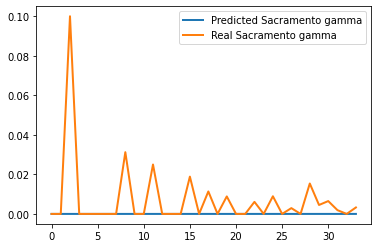

In [22]:
x = range(len(R0_Sacramento))
y1 = gamma_Sacramento
y2 = gamma_lst[202][:34]
plt.plot(x, y1, ls="-", lw=2, label="Predicted Sacramento gamma")
plt.plot(x, y2, ls="-", lw=2, label="Real Sacramento gamma")
plt.legend()
plt.show()

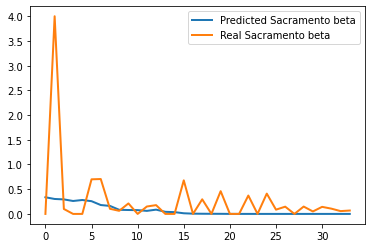

In [23]:
x = range(len(R0_Sacramento))
y1 = beta_Sacramento
y2 = beta_lst[202][:34]
plt.plot(x, y1, ls="-", lw=2, label="Predicted Sacramento beta")
plt.plot(x, y2, ls="-", lw=2, label="Real Sacramento beta")
plt.legend()
plt.show()

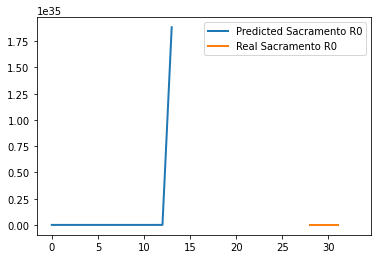

In [24]:
x = range(len(R0_Sacramento))
y1 = R0_Sacramento
y2 = train_R0_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted Sacramento R0")
plt.plot(x, y2, ls="-", lw=2, label="Real Sacramento R0")
plt.legend()
plt.show()

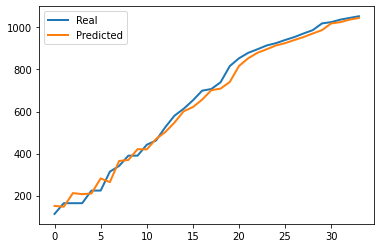

In [25]:
pred_vals = []
for i in range(len(train_past_cases_1d)):
    pred_vals.append(train_vals[i][202].cpu().numpy())

x = range(len(pred_vals))
y1 = train_labels_Sacramento
y2 = pred_vals
plt.plot(x, y1, ls="-", lw=2, label="Real")
plt.plot(x, y2, ls="-", lw=2, label="Predicted")
plt.legend()
plt.show()

In [26]:
for i,j,k in zip(beta_Sacramento, gamma_Sacramento, R0_Sacramento):
    print(i, j, k)

tensor(0.3368, device='cuda:0') tensor(2.4412e-07, device='cuda:0') tensor(1379488.7500, device='cuda:0')
tensor(0.3024, device='cuda:0') tensor(6.5986e-08, device='cuda:0') tensor(4583141.5000, device='cuda:0')
tensor(0.2938, device='cuda:0') tensor(7.0672e-10, device='cuda:0') tensor(4.1572e+08, device='cuda:0')
tensor(0.2616, device='cuda:0') tensor(6.2589e-11, device='cuda:0') tensor(4.1790e+09, device='cuda:0')
tensor(0.2817, device='cuda:0') tensor(4.1445e-12, device='cuda:0') tensor(6.7959e+10, device='cuda:0')
tensor(0.2576, device='cuda:0') tensor(8.3206e-14, device='cuda:0') tensor(3.0956e+12, device='cuda:0')
tensor(0.1798, device='cuda:0') tensor(1.4057e-15, device='cuda:0') tensor(1.2792e+14, device='cuda:0')
tensor(0.1618, device='cuda:0') tensor(9.4588e-19, device='cuda:0') tensor(1.7102e+17, device='cuda:0')
tensor(0.0830, device='cuda:0') tensor(1.4722e-20, device='cuda:0') tensor(5.6375e+18, device='cuda:0')
tensor(0.0791, device='cuda:0') tensor(1.5748e-24, device='c

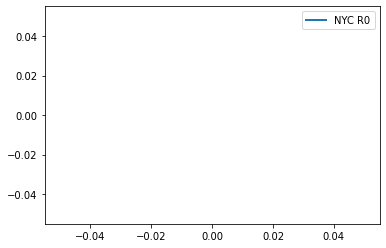

In [27]:
x = range(len(R0_NYC))
y_NYC = R0_NYC
plt.plot(x, y_NYC, ls="-", lw=2, label="NYC R0")
plt.legend()
plt.show()

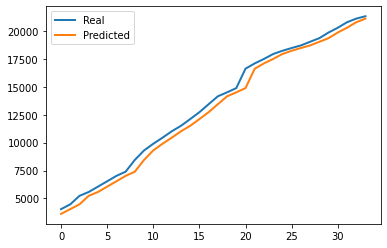

In [28]:
pred_vals_NYC = []
for i in range(len(R0_NYC)):
    pred_vals_NYC.append(train_vals[i][4].cpu().numpy())

x = range(len(R0_NYC))
y1 = train_labels_NYC
y2 = pred_vals_NYC
plt.plot(x, y1, ls="-", lw=2, label="Real")
plt.plot(x, y2, ls="-", lw=2, label="Predicted")
plt.legend()
plt.show()

In [29]:
for i,j,k in zip(beta_NYC, gamma_NYC, R0_NYC):
    print(i, j, k)

tensor(0.0008, device='cuda:0') tensor(0., device='cuda:0') tensor(inf, device='cuda:0')
tensor(2.9051e-06, device='cuda:0') tensor(0., device='cuda:0') tensor(inf, device='cuda:0')
tensor(4.2486e-08, device='cuda:0') tensor(0., device='cuda:0') tensor(inf, device='cuda:0')
tensor(7.7956e-10, device='cuda:0') tensor(0., device='cuda:0') tensor(inf, device='cuda:0')
tensor(3.6747e-11, device='cuda:0') tensor(0., device='cuda:0') tensor(inf, device='cuda:0')
tensor(3.0998e-11, device='cuda:0') tensor(0., device='cuda:0') tensor(inf, device='cuda:0')
tensor(5.7136e-14, device='cuda:0') tensor(0., device='cuda:0') tensor(inf, device='cuda:0')
tensor(2.7240e-15, device='cuda:0') tensor(0., device='cuda:0') tensor(inf, device='cuda:0')
tensor(1.0187e-17, device='cuda:0') tensor(0., device='cuda:0') tensor(inf, device='cuda:0')
tensor(1.0169e-22, device='cuda:0') tensor(0., device='cuda:0') tensor(inf, device='cuda:0')
tensor(1.0573e-25, device='cuda:0') tensor(0., device='cuda:0') tensor(inf

## GAT - SIR

In [19]:
hidden_size = 100
learning_rate = 0.0000005
num_epochs = 1000
batch_size = 1000
output_size = 2

device = th.device('cuda:0')
input_size = train_past_cases_1d[0].shape[1] + attrs.shape[1]
gat_sir = GAT_SIR(g, input_size, hidden_size, output_size, 1)
print('#features:', input_size)

# Move model to GPU
gat_sir = gat_sir.to(device)

# Move data to GPU
pop = pop.to(device)
attrs = attrs.to(device)
for i in range(len(train_past_cases_1d)):
    train_past_cases_1d[i] = train_past_cases_1d[i].to(device)
    train_past_deaths_1d[i] = train_past_deaths_1d[i].to(device)
    train_labels_cases_1d[i] = train_labels_cases_1d[i].to(device)
    train_labels_deaths_1d[i] = train_labels_deaths_1d[i].to(device)
    if len(train_labels_cases_1d[i].shape) == 1:
        train_labels_cases_1d[i] = train_labels_cases_1d[i].unsqueeze(1)
    if len(train_labels_deaths_1d[i].shape) == 1:
        train_labels_deaths_1d[i] = train_labels_deaths_1d[i].unsqueeze(1)
        
for i in range(len(valid_past_cases_1d)):
    valid_past_cases_1d[i] = valid_past_cases_1d[i].to(device)
    valid_past_deaths_1d[i] = valid_past_deaths_1d[i].to(device)
    valid_labels_cases_1d[i] = valid_labels_cases_1d[i].to(device)
    valid_labels_deaths_1d[i] = valid_labels_deaths_1d[i].to(device)
    if len(valid_labels_cases_1d[i].shape) == 1:
         valid_labels_cases_1d[i] = valid_labels_cases_1d[i].unsqueeze(1)
    if len(test_labels_deaths_1d[i].shape) == 1:
        valid_labels_deaths_1d[i] = valid_labels_deaths_1d[i].unsqueeze(1)

for i in range(len(test_past_cases_1d)):
    test_past_cases_1d[i] = test_past_cases_1d[i].to(device)
    test_past_deaths_1d[i] = test_past_deaths_1d[i].to(device)
    test_labels_cases_1d[i] = test_labels_cases_1d[i].to(device)
    test_labels_deaths_1d[i] = test_labels_deaths_1d[i].to(device)
    if len(test_labels_cases_1d[i].shape) == 1:
        test_labels_cases_1d[i] = test_labels_cases_1d[i].unsqueeze(1)
    if len(test_labels_deaths_1d[i].shape) == 1:
        test_labels_deaths_1d[i] = test_labels_deaths_1d[i].unsqueeze(1)
        
# Normalize attrs
attrs[th.isnan(attrs)] = 0
attr_mean = th.mean(attrs, dim=1, keepdim=True)
attrs = attrs - attr_mean
attr_std = th.std(attrs, dim=1, keepdim=True)
attrs = attrs / attr_std

new_eval_err = 1000
optimizer = th.optim.Adam(gat_sir.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    losses = []
    for idx in range(len(train_past_cases_1d)):
        labels_cases = train_labels_cases_1d[idx]
        labels_deaths = train_labels_deaths_1d[idx]
        batch = th.cat([train_past_cases_1d[idx], attrs], dim=1)
        th.manual_seed(1)
        vals = gat_sir(batch)
        I = train_past_cases_1d[idx][:,-1].view(3142,1)
        D = train_past_deaths_1d[idx][:,-1].view(3142,1)
        I_new, D_new = sir_1d_output(vals, I, D)
        loss = my_msle_ID(I_new, D_new, labels_cases, labels_deaths)
        loss.backward(retain_graph=True)
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
    
    count = 0
    with th.no_grad():
        eval_errs = []
        test_errs = []
        test_mses = []
        test_maes = []
        for idx in range(14):
            valid_feats = th.cat([valid_past_cases_1d[idx], attrs], dim=1)
            eval_vals = gat_sir(valid_feats)
            eval_I = valid_past_cases_1d[idx][:,-1].view(3142,1)
            eval_D = valid_past_deaths_1d[idx][:,-1].view(3142,1)
            eval_labels_cases = valid_labels_cases_1d[idx]
            eval_labels_deaths = valid_labels_deaths_1d[idx]
            eval_I_new, eval_D_new = sir_1d_output(eval_vals, eval_I, eval_D)
            err = my_msle_ID(eval_I_new, eval_D_new, eval_labels_cases, eval_labels_deaths)
            eval_errs.append(err.cpu().numpy())
        

            test_feats = th.cat([test_past_cases_1d[idx], attrs], dim=1)
            test_vals = gat_sir(test_feats)
            test_I = test_past_cases_1d[idx][:,-1].view(3142,1)
            test_D = test_past_deaths_1d[idx][:,-1].view(3142,1)
            test_cases = test_labels_cases_1d[idx]
            test_deaths = test_labels_deaths_1d[idx]
            test_I_new, test_D_new = sir_1d_output(test_vals, test_I, test_D)
            test_err = my_msle_ID(test_I_new, test_D_new, test_cases, test_deaths)
            test_mse = th.mean((test_I_new - test_labels_cases_1d[idx])**2)
            test_mae = th.mean(th.abs(test_I_new - test_labels_cases_1d[idx]))
            test_errs.append(test_err.cpu().numpy())
            test_mses.append(test_mse.cpu().numpy())
            test_maes.append(test_mae.cpu().numpy())
        print('epoch={}, loss={:.3f}, validation loss = {:.3f}, test loss={:.3f}, test mse = {:.3f}, test mae = {:.3f}'.format(epoch, np.mean(losses), np.mean(eval_errs), np.mean(test_errs), np.mean(test_mses), np.mean(test_maes)))
#        old_eval_err = new_eval_err
#        new_eval_err = np.mean(eval_errs)
#        if old_eval_err <= new_eval_err:
#            R0_NYC = []
#            R0_Sacramento = []
#            gamma_NYC = []
#            beta_NYC = []
#            gamma_Sacramento = []
#            beta_Sacramento = []
#            train_vals = []
#            for idx in range(19, len(train_past_cases)):
#                labels = train_labels_cases[idx]
#                batch = th.cat([train_past_cases[idx], attrs], dim=1)
#                th.manual_seed(1)
#                vals = mlp_sir(batch)
#                gamma_NYC.append(vals[4][0])
#                gamma_Sacramento.append(vals[202][0])
#                beta_NYC.append(vals[4][0])
#                beta_Sacramento.append(vals[202][0])
#                R_NYC_div = th.div(vals[4][1],vals[4][0])
#                R_Sacramento_div = th.div(vals[202][1],vals[202][0])
#                R0_NYC.append(R_NYC_div)
#                R0_Sacramento.append(R_Sacramento_div)
#                I = train_past_cases[idx][:,-1].view(3142,1)
#                D = train_past_deaths[idx][:,-1].view(3142,1)
#                I_new, D_new = sir_1d_output(vals, I, D)
#                train_vals.append(I_new)
#            break
#    print('epoch={}, loss={:.3f}, validation loss = {:.3f}'.format(epoch, np.mean(losses), np.mean(eval_errs)))

#features: 97


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


epoch=0, loss=3.625, validation loss = 6.414, test loss=7.538, test mse = 1328139.375, test mae = 143.040
epoch=1, loss=2.515, validation loss = 3.597, test loss=3.902, test mse = 57905.730, test mae = 42.500
epoch=2, loss=1.733, validation loss = 2.053, test loss=2.063, test mse = 22330.891, test mae = 22.573
epoch=3, loss=1.224, validation loss = 1.128, test loss=1.025, test mse = 14337.678, test mae = 14.574
epoch=4, loss=0.906, validation loss = 0.690, test loss=0.568, test mse = 3302.091, test mae = 9.957
epoch=5, loss=0.732, validation loss = 0.482, test loss=0.362, test mse = 3236.597, test mae = 9.140
epoch=6, loss=0.621, validation loss = 0.355, test loss=0.251, test mse = 3303.890, test mae = 8.981
epoch=7, loss=0.541, validation loss = 0.271, test loss=0.190, test mse = 4346.214, test mae = 9.590
epoch=8, loss=0.480, validation loss = 0.216, test loss=0.152, test mse = 5454.673, test mae = 10.301
epoch=9, loss=0.432, validation loss = 0.179, test loss=0.126, test mse = 7198.

epoch=78, loss=0.056, validation loss = 0.019, test loss=0.015, test mse = 1829705.375, test mae = 49.984
epoch=79, loss=0.055, validation loss = 0.019, test loss=0.015, test mse = 1820590.875, test mae = 47.375
epoch=80, loss=0.055, validation loss = 0.018, test loss=0.014, test mse = 1531372.000, test mae = 40.114
epoch=81, loss=0.054, validation loss = 0.017, test loss=0.013, test mse = 9044.791, test mae = 11.259
epoch=82, loss=0.053, validation loss = 0.017, test loss=0.013, test mse = 5571.063, test mae = 9.714
epoch=83, loss=0.053, validation loss = 0.017, test loss=0.012, test mse = 3534.174, test mae = 8.786
epoch=84, loss=0.052, validation loss = 0.016, test loss=0.012, test mse = 2105.562, test mae = 7.907
epoch=85, loss=0.052, validation loss = 0.016, test loss=0.011, test mse = 1669.316, test mae = 7.449
epoch=86, loss=0.051, validation loss = 0.016, test loss=0.011, test mse = 1603.136, test mae = 7.280
epoch=87, loss=0.050, validation loss = 0.015, test loss=0.011, test 

epoch=158, loss=0.037, validation loss = 0.012, test loss=0.009, test mse = 1587.993, test mae = 6.931
epoch=159, loss=0.037, validation loss = 0.012, test loss=0.009, test mse = 1587.993, test mae = 6.930
epoch=160, loss=0.037, validation loss = 0.012, test loss=0.009, test mse = 1587.993, test mae = 6.930
epoch=161, loss=0.037, validation loss = 0.012, test loss=0.009, test mse = 1587.993, test mae = 6.929
epoch=162, loss=0.037, validation loss = 0.012, test loss=0.009, test mse = 1587.993, test mae = 6.929
epoch=163, loss=0.037, validation loss = 0.012, test loss=0.009, test mse = 1587.993, test mae = 6.929
epoch=164, loss=0.037, validation loss = 0.012, test loss=0.009, test mse = 1587.993, test mae = 6.928
epoch=165, loss=0.037, validation loss = 0.012, test loss=0.009, test mse = 1587.993, test mae = 6.928
epoch=166, loss=0.037, validation loss = 0.012, test loss=0.009, test mse = 1587.993, test mae = 6.928
epoch=167, loss=0.037, validation loss = 0.012, test loss=0.009, test mse

KeyboardInterrupt: 

In [20]:
with th.no_grad():
    R0_NYC = []
    R0_Sacramento = []
    gamma_NYC = []
    beta_NYC = []
    gamma_Sacramento = []
    beta_Sacramento = []
    train_vals = []
    for idx in range(19, len(train_past_cases_1d)):
        labels = train_labels_cases_1d[idx]
        batch = th.cat([train_past_cases_1d[idx], attrs], dim=1)
        th.manual_seed(1)
        vals = gat_sir(batch)
        gamma_NYC.append(vals[4][0])
        gamma_Sacramento.append(vals[202][0])
        beta_NYC.append(vals[4][1])
        beta_Sacramento.append(vals[202][1])
        R_NYC_div = th.div(vals[4][1],vals[4][0])
        R_Sacramento_div = th.div(vals[202][1],vals[202][0])
        R0_NYC.append(R_NYC_div)
        R0_Sacramento.append(R_Sacramento_div)  
        I = train_past_cases_1d[idx][:,-1].view(3142,1)
        D = train_past_deaths_1d[idx][:,-1].view(3142,1)
        I_new, D_new = sir_1d_output(vals, I, D)
        train_vals.append(I_new)

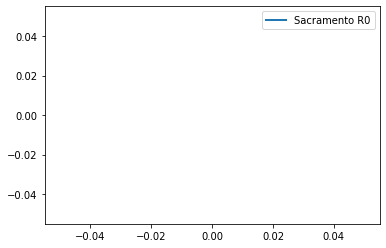

In [21]:
x = range(len(R0_Sacramento))
y1 = R0_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Sacramento R0")
plt.legend()
plt.show()

In [23]:
pred_vals = []
for i in range(len(train_past_cases_1d)):
    pred_vals.append(train_vals[i][202].cpu().numpy())

x = range(len(pred_vals))
y1 = train_labels_Sacramento
y2 = pred_vals
plt.plot(x, y1, ls="-", lw=2, label="Real")
plt.plot(x, y2, ls="-", lw=2, label="Predicted")
plt.legend()
plt.show()

IndexError: list index out of range

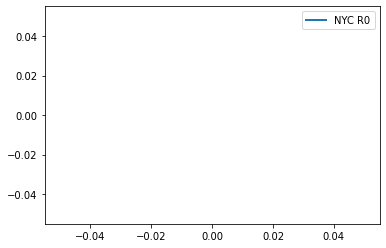

In [68]:
x = range(len(R0_NYC))
y_NYC = R0_NYC
plt.plot(x, y_NYC, ls="-", lw=2, label="NYC R0")
plt.legend()
plt.show()

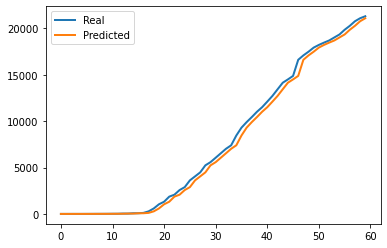

In [69]:
pred_vals_NYC = []
for i in range(79-19):
    pred_vals_NYC.append(train_vals[i][4].cpu().numpy())

x = range(60)
y1 = train_labels_NYC
y2 = pred_vals_NYC
plt.plot(x, y1, ls="-", lw=2, label="Real")
plt.plot(x, y2, ls="-", lw=2, label="Predicted")
plt.legend()
plt.show()

# 7-day Predictions

## Prepare Data

In [33]:
attr_cols = []

# Set the variable to True if we want to specify features ourselves.
use_specified_fields = False

if use_specified_fields:
    f = open("fields.txt", "r")
    fields = f.readlines()
    for field in fields:
        field = field.rstrip()
        arr = np.array(df[field])
        if arr.dtype == np.float32 or arr.dtype == np.float64:
            attr_cols.append(np.array(arr, dtype=np.float32))
else:
    for i in range(6, 86):
        arr = np.array(df[keys[i]])
        if arr.dtype == np.float32 or arr.dtype == np.float64:
            attr_cols.append(np.array(arr, dtype=np.float32))

attrs = th.tensor(np.stack(attr_cols, 1), dtype=th.float32)
cases = []
# for i in range(87, 216):
for i in range(132, 216):
    cases.append(np.array(df[keys[i]]))
cases = np.stack(cases, 1)
deaths = []
# for i in range(218, 347):
for i in range(263, 347):
    deaths.append(np.array(df[keys[i]]))
deaths = np.stack(deaths, 1)

pop = attrs[:,5]
pop = pop.view(3142, 1)
pop[1834] = 1 

print('attrs:', attrs.shape)
print('cases:', cases.shape)
print('deaths:', deaths.shape)
print(attrs[0])
print(cases[0])
print(deaths[0])

attrs: torch.Size([3142, 78])
cases: (3142, 84)
deaths: (3142, 84)
tensor([ 4.0641e+01, -7.3955e+01,  4.0651e+01, -7.3955e+01,  1.0000e+00,
         2.5828e+06,  1.2550e+06,  1.3938e+06,  4.7379e-01,  3.5671e+05,
         3.5369e+04,  2.5047e+06,  3.4100e+01,  3.8667e+05,  3.0966e+05,
         6.3500e+02,  9.7000e+00,  1.9580e+02,  1.9500e+01,  1.3841e+01,
         2.3050e+01,  3.5442e+04,  9.3070e+03,  6.0000e+00,  1.2000e+01,
         3.1800e+02,  4.5415e+00,  9.0415e+04,  8.6783e+04,  8.1356e+04,
         7.8035e+04,  7.9604e+04,  7.6959e+04,  8.6716e+04,  8.3968e+04,
         9.6663e+04,  9.9134e+04,  1.0605e+05,  1.1679e+05,  9.7154e+04,
         1.0570e+05,  1.6196e+05,  1.7958e+05,  1.4949e+05,  1.7469e+05,
         6.3789e+04,  7.8116e+04,  5.5241e+04,  6.8866e+04,  6.4628e+04,
         8.8066e+04,  3.5780e+04,  5.8209e+04,  1.2524e+04,  2.8426e+04,
         1.5400e+02,  2.4000e+01,  3.3000e+01,  1.5100e+02,  3.4100e+02,
         4.9300e+02,  1.1160e+03,  2.1390e+03,  2.8520e+0

In [34]:
num_days = cases.shape[1]
num_valid_days = 15
num_test_days = 15
train_valid_split = num_days - num_valid_days - num_test_days
valid_test_split = num_days - num_test_days
in_len = 20
out_len = 7
out_size = 7

train_past_cases = []
train_past_deaths = []
train_labels_cases = []
train_labels_deaths = []
for start in range(14):
    end = start + in_len + out_len - 1
    end_begin = end - out_len
    train_past_cases.append(th.tensor(cases[:,start:end_begin], dtype=th.float32))
    #train_past_deaths.append(th.mul(th.tensor(deaths[:,start:end_begin], dtype=th.float32),1))
    train_past_deaths.append(th.mul(th.tensor(deaths[:,start:end_begin], dtype=th.float32),1))
    train_labels_cases.append(th.tensor(cases[:,end_begin:end], dtype=th.float32))
    #train_labels_deaths.append(th.mul(th.tensor(deaths[:,end_begin:end], dtype=th.float32),1))
    train_labels_deaths.append(th.mul(th.tensor(deaths[:,end_begin:end], dtype=th.float32),1))

for start in range(14, train_valid_split - in_len - out_len + 1):
    end = start + in_len + out_len - 1
    end_begin = end - out_len
    train_past_cases.append(th.tensor(cases[:,start:end_begin], dtype=th.float32))
    #train_past_deaths.append(th.mul(th.tensor(deaths[:,start:end_begin], dtype=th.float32),1))
    train_past_deaths.append(th.mul(th.tensor(cases[:,start-14:end_begin-14], dtype=th.float32),1))
    train_labels_cases.append(th.tensor(cases[:,end_begin:end], dtype=th.float32))
    #train_labels_deaths.append(th.mul(th.tensor(deaths[:,end_begin:end], dtype=th.float32),1))
    train_labels_deaths.append(th.mul(th.tensor(cases[:,end_begin-14:end-14], dtype=th.float32),1))

valid_past_cases = []
valid_past_deaths = []
valid_labels_cases = []
valid_labels_deaths = []
for start in range(train_valid_split - in_len - out_len + 1, valid_test_split - in_len - out_len):
    end = start + in_len + out_len - 1
    end_begin = end - out_len
    valid_past_cases.append(th.tensor(cases[:,start:end_begin], dtype=th.float32))
    #valid_past_deaths.append(th.mul(th.tensor(deaths[:,start:end_begin], dtype=th.float32),50))
    valid_past_deaths.append(th.mul(th.tensor(cases[:,start-14:end_begin-14], dtype=th.float32),1))
    valid_labels_cases.append(th.tensor(cases[:,end_begin:end], dtype=th.float32))
    #valid_labels_deaths.append(th.mul(th.tensor(deaths[:,end_begin:end], dtype=th.float32),50))
    valid_labels_deaths.append(th.mul(th.tensor(cases[:,end_begin-14:end-14], dtype=th.float32),1))
    
test_past_cases = []
test_past_deaths = []
test_labels_cases = []
test_labels_deaths = []
for start in range(valid_test_split - in_len - out_len + 1, num_days - in_len - out_len):
    end = start + in_len + out_len - 1
    end_begin = end - out_len
    test_past_cases.append(th.tensor(cases[:,start:end_begin], dtype=th.float32))
    # test_past_deaths.append(th.mul(th.tensor(deaths[:,start:end_begin], dtype=th.float32),50))
    test_past_deaths.append(th.mul(th.tensor(cases[:,start-14:end_begin-14], dtype=th.float32),1))
    test_labels_cases.append(th.tensor(cases[:,end_begin:end], dtype=th.float32))
    #test_labels_deaths.append(th.mul(th.tensor(deaths[:,end_begin:end], dtype=th.float32),50))
    test_labels_deaths.append(th.mul(th.tensor(cases[:,end_begin-1:end-1], dtype=th.float32),1))

## Helper Functions

In [35]:
def sir_output(params, I, D):
    gamma = params[:,0]
    beta = params[:,1]
    I[I != I] = 0.0
    D[D != D] = 0.0
    err = th.tensor([0],dtype=th.float)
    err = err.to(device)
    S = pop - I - D
    I_lst = []
    D_lst = []
    for i in range(7):
        S_new = th.add(S, - th.div(th.mul(beta.view(3142,1), th.mul(S, I)), pop))
        I_new = th.add(th.add(I, th.mul(beta.view(3142,1), th.div(th.mul(S,I), pop))), - th.mul(gamma.view(3142,1), I))
        D_new = th.add(D, th.mul(gamma.view(3142,1), I))
        I_lst.append(I_new)
        D_lst.append(D_new)
        S = S_new
        I = I_new
        D = D_new
    return th.cat(I_lst, dim = 1), th.cat(D_lst, dim = 1)

## Training Loop

### MLP - SIR

In [36]:
hidden_size = 100
learning_rate = 0.0000005
num_epochs = 1000
batch_size = 1000
output_size = 2

device = th.device('cuda:0')
input_size = train_past_cases[0].shape[1] + attrs.shape[1]
mlp_sir = Net_SIR(input_size, hidden_size, output_size)
print('#features:', input_size)

# Move model to GPU
mlp_sir = mlp_sir.to(device)
# TODO we might want to choose a better loss.
# L2 loss will penalize the data points with larger deaths more. Is this what we want?
# criterion = criterion.to(device)

# Move data to GPU
pop = pop.to(device)
attrs = attrs.to(device)
for i in range(len(train_past_cases)):
    train_past_cases[i] = train_past_cases[i].to(device)
    train_past_deaths[i] = train_past_deaths[i].to(device)
    train_labels_cases[i] = train_labels_cases[i].to(device)
    train_labels_deaths[i] = train_labels_deaths[i].to(device)
    if len(train_labels_cases[i].shape) == 1:
        train_labels_cases[i] = train_labels_cases[i].unsqueeze(1)
    if len(train_labels_deaths[i].shape) == 1:
        train_labels_deaths[i] = train_labels_deaths[i].unsqueeze(1)
        
for i in range(len(valid_past_cases)):
    valid_past_cases[i] = valid_past_cases[i].to(device)
    valid_past_deaths[i] = valid_past_deaths[i].to(device)
    valid_labels_cases[i] = valid_labels_cases[i].to(device)
    valid_labels_deaths[i] = valid_labels_deaths[i].to(device)
    if len(valid_labels_cases[i].shape) == 1:
         valid_labels_cases[i] = valid_labels_cases[i].unsqueeze(1)
    if len(test_labels_deaths[i].shape) == 1:
        valid_labels_deaths[i] = valid_labels_deaths[i].unsqueeze(1)

for i in range(len(test_past_cases)):
    test_past_cases[i] = test_past_cases[i].to(device)
    test_past_deaths[i] = test_past_deaths[i].to(device)
    test_labels_cases[i] = test_labels_cases[i].to(device)
    test_labels_deaths[i] = test_labels_deaths[i].to(device)
    if len(test_labels_cases[i].shape) == 1:
        test_labels_cases[i] = test_labels_cases[i].unsqueeze(1)
    if len(test_labels_deaths[i].shape) == 1:
        test_labels_deaths[i] = test_labels_deaths[i].unsqueeze(1)
        
# Normalize attrs
attrs[th.isnan(attrs)] = 0
attr_mean = th.mean(attrs, dim=1, keepdim=True)
attrs = attrs - attr_mean
attr_std = th.std(attrs, dim=1, keepdim=True)
attrs = attrs / attr_std

optimizer = th.optim.Adam(mlp_sir.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    losses = []
    for idx in range(19, len(train_past_cases)):
        labels_cases = train_labels_cases[idx]
        labels_deaths = train_labels_deaths[idx]
        batch = th.cat([train_past_cases[idx], attrs], dim=1)
        th.manual_seed(1)
        vals = mlp_sir(batch)
        I = train_past_cases[idx][:,-1].view(3142,1)
        D = train_past_deaths[idx][:,-1].view(3142,1)
        I_new, D_new = sir_output(vals, I, D)
        loss = my_msle_ID(I_new, D_new, labels_cases, labels_deaths)
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
    
    with th.no_grad():
        eval_errs = []
        test_errs = []
        test_mses = []
        test_maes = []
        for idx in range(6):
            valid_feats = th.cat([valid_past_cases[idx], attrs], dim=1)
            eval_vals = mlp_sir(valid_feats)
            eval_I = valid_past_cases[idx][:,-1].view(3142,1)
            eval_D = valid_past_deaths[idx][:,-1].view(3142,1)
            eval_labels_cases = valid_labels_cases[idx]
            eval_labels_deaths = valid_labels_deaths[idx]
            eval_I_new, eval_D_new = sir_output(eval_vals, eval_I, eval_D)
            err = my_msle_ID(eval_I_new, eval_D_new, eval_labels_cases, eval_labels_deaths)
            eval_errs.append(err.cpu().numpy())
            
            
            test_feats = th.cat([test_past_cases[idx], attrs], dim=1)
            test_vals = mlp_sir(test_feats)
            test_I = test_past_cases[idx][:,-1].view(3142,1)
            test_D = test_past_deaths[idx][:,-1].view(3142,1)
            test_cases = test_labels_cases[idx]
            test_deaths = test_labels_deaths[idx]
            test_I_new, test_D_new = sir_output(test_vals, test_I, test_D)
            test_err = my_msle_ID(test_I_new, test_D_new, test_cases, test_deaths)
            test_mse = th.mean((test_I_new - test_labels_cases[idx])**2)
            test_mae = th.mean(th.abs(test_I_new - test_labels_cases[idx]))
            test_errs.append(test_err.cpu().numpy())
            test_mses.append(test_mse.cpu().numpy())
            test_maes.append(test_mae.cpu().numpy())
        print('epoch={}, loss={:.3f}, validation loss = {:.3f}, test loss={:.3f}, test mse = {:.3f}, test mae = {:.3f}'.format(epoch, np.mean(losses), np.mean(eval_errs), np.mean(test_errs), np.mean(test_mses), np.mean(test_maes)))
            
#        if np.mean(eval_errs) <= 0.054:
#            R0_NYC = []
#            R0_Sacramento = []
#            gamma_NYC = []
#            beta_NYC = []
#            gamma_Sacramento = []
#            beta_Sacramento = []
#            train_vals = []
#            for idx in range(19, len(train_past_cases)):
#                labels = train_labels_cases[idx]
#                batch = th.cat([train_past_cases[idx], attrs], dim=1)
#                th.manual_seed(1)
#                vals = mlp_sir(batch)
#                gamma_NYC.append(vals[4][0])
#                gamma_Sacramento.append(vals[202][0])
#                beta_NYC.append(vals[4][1])
#                beta_Sacramento.append(vals[202][1])
#                R_NYC_div = th.div(vals[4][1],vals[4][0])
#                R_Sacramento_div = th.div(vals[202][1],vals[202][0])
#                R0_NYC.append(R_NYC_div)
#                R0_Sacramento.append(R_Sacramento_div)  
#                I = train_past_cases[idx][:,-1].view(3142,1)
#                D = train_past_deaths[idx][:,-1].view(3142,1)
#                output = sir_output(vals, I, D, labels)
#                train_vals.append(output)
#            break
#        print('epoch={}, loss={:.3f}, validation loss = {:.3f}, test loss={:.3f}, test mse = {:.3f}, test mae = {:.3f}'.format(epoch, np.mean(losses), np.mean(eval_errs), np.mean(test_errs), np.mean(test_mses), np.mean(test_maes)))

#features: 97
epoch=0, loss=3.338, validation loss = 4.170, test loss=4.432, test mse = 7348628.000, test mae = 413.594
epoch=1, loss=3.301, validation loss = 4.113, test loss=4.329, test mse = 7355843.500, test mae = 413.069
epoch=2, loss=3.259, validation loss = 4.048, test loss=4.204, test mse = 7364558.000, test mae = 412.442
epoch=3, loss=3.213, validation loss = 3.973, test loss=4.059, test mse = 7374425.500, test mae = 411.674
epoch=4, loss=3.163, validation loss = 3.890, test loss=3.890, test mse = 7385044.000, test mae = 410.764
epoch=5, loss=3.109, validation loss = 3.796, test loss=3.691, test mse = 7395536.000, test mae = 409.567
epoch=6, loss=3.051, validation loss = 3.691, test loss=3.452, test mse = 7403334.500, test mae = 407.851
epoch=7, loss=2.990, validation loss = 3.571, test loss=3.162, test mse = 7397291.500, test mae = 405.106
epoch=8, loss=2.922, validation loss = 3.432, test loss=2.789, test mse = 7233640.500, test mae = 397.638
epoch=9, loss=2.848, validation 

epoch=77, loss=1.503, validation loss = 1.218, test loss=0.588, test mse = 2758240.750, test mae = 111.109
epoch=78, loss=1.499, validation loss = 1.216, test loss=0.588, test mse = 2675845.750, test mae = 109.878
epoch=79, loss=1.496, validation loss = 1.213, test loss=0.587, test mse = 2595299.250, test mae = 108.647
epoch=80, loss=1.492, validation loss = 1.211, test loss=0.587, test mse = 2515777.000, test mae = 107.419
epoch=81, loss=1.488, validation loss = 1.209, test loss=0.586, test mse = 2436730.250, test mae = 106.193
epoch=82, loss=1.485, validation loss = 1.206, test loss=0.586, test mse = 2357792.250, test mae = 104.969
epoch=83, loss=1.481, validation loss = 1.204, test loss=0.585, test mse = 2278160.250, test mae = 103.740
epoch=84, loss=1.477, validation loss = 1.202, test loss=0.584, test mse = 2197606.500, test mae = 102.513
epoch=85, loss=1.474, validation loss = 1.199, test loss=0.584, test mse = 2115377.250, test mae = 101.282
epoch=86, loss=1.470, validation loss

epoch=155, loss=1.264, validation loss = 1.042, test loss=0.519, test mse = 38458.137, test mae = 47.627
epoch=156, loss=1.262, validation loss = 1.040, test loss=0.518, test mse = 38184.855, test mae = 47.384
epoch=157, loss=1.260, validation loss = 1.038, test loss=0.517, test mse = 37926.285, test mae = 47.145
epoch=158, loss=1.258, validation loss = 1.036, test loss=0.516, test mse = 37680.457, test mae = 46.911
epoch=159, loss=1.256, validation loss = 1.035, test loss=0.515, test mse = 37445.691, test mae = 46.681
epoch=160, loss=1.254, validation loss = 1.033, test loss=0.515, test mse = 37220.363, test mae = 46.456
epoch=161, loss=1.252, validation loss = 1.031, test loss=0.514, test mse = 37003.148, test mae = 46.237
epoch=162, loss=1.251, validation loss = 1.029, test loss=0.513, test mse = 36792.848, test mae = 46.022
epoch=163, loss=1.249, validation loss = 1.028, test loss=0.512, test mse = 36588.324, test mae = 45.812
epoch=164, loss=1.247, validation loss = 1.026, test lo

epoch=236, loss=1.140, validation loss = 0.919, test loss=0.467, test mse = 30833.828, test mae = 36.429
epoch=237, loss=1.139, validation loss = 0.918, test loss=0.467, test mse = 30821.967, test mae = 36.356
epoch=238, loss=1.137, validation loss = 0.917, test loss=0.466, test mse = 30810.398, test mae = 36.284
epoch=239, loss=1.136, validation loss = 0.915, test loss=0.466, test mse = 30799.096, test mae = 36.213
epoch=240, loss=1.135, validation loss = 0.914, test loss=0.465, test mse = 30788.057, test mae = 36.143
epoch=241, loss=1.134, validation loss = 0.913, test loss=0.465, test mse = 30777.283, test mae = 36.073
epoch=242, loss=1.132, validation loss = 0.912, test loss=0.465, test mse = 30766.764, test mae = 36.004
epoch=243, loss=1.131, validation loss = 0.910, test loss=0.464, test mse = 30756.490, test mae = 35.936
epoch=244, loss=1.130, validation loss = 0.909, test loss=0.464, test mse = 30746.447, test mae = 35.869
epoch=245, loss=1.129, validation loss = 0.908, test lo

epoch=317, loss=1.051, validation loss = 0.830, test loss=0.436, test mse = 30371.674, test mae = 32.601
epoch=318, loss=1.050, validation loss = 0.829, test loss=0.436, test mse = 30369.219, test mae = 32.571
epoch=319, loss=1.049, validation loss = 0.828, test loss=0.436, test mse = 30366.803, test mae = 32.542
epoch=320, loss=1.048, validation loss = 0.827, test loss=0.435, test mse = 30364.420, test mae = 32.513
epoch=321, loss=1.047, validation loss = 0.826, test loss=0.435, test mse = 30362.078, test mae = 32.483
epoch=322, loss=1.047, validation loss = 0.825, test loss=0.435, test mse = 30359.768, test mae = 32.455
epoch=323, loss=1.046, validation loss = 0.824, test loss=0.434, test mse = 30357.494, test mae = 32.426
epoch=324, loss=1.045, validation loss = 0.823, test loss=0.434, test mse = 30355.256, test mae = 32.398
epoch=325, loss=1.044, validation loss = 0.822, test loss=0.434, test mse = 30353.053, test mae = 32.369
epoch=326, loss=1.043, validation loss = 0.821, test lo

epoch=398, loss=0.980, validation loss = 0.759, test loss=0.415, test mse = 30256.740, test mae = 30.831
epoch=399, loss=0.980, validation loss = 0.758, test loss=0.415, test mse = 30256.076, test mae = 30.817
epoch=400, loss=0.979, validation loss = 0.757, test loss=0.414, test mse = 30255.420, test mae = 30.803
epoch=401, loss=0.978, validation loss = 0.757, test loss=0.414, test mse = 30254.775, test mae = 30.789
epoch=402, loss=0.977, validation loss = 0.756, test loss=0.414, test mse = 30254.141, test mae = 30.775
epoch=403, loss=0.976, validation loss = 0.755, test loss=0.414, test mse = 30253.523, test mae = 30.762
epoch=404, loss=0.976, validation loss = 0.754, test loss=0.414, test mse = 30252.906, test mae = 30.748
epoch=405, loss=0.975, validation loss = 0.754, test loss=0.413, test mse = 30252.307, test mae = 30.735
epoch=406, loss=0.974, validation loss = 0.753, test loss=0.413, test mse = 30251.713, test mae = 30.722
epoch=407, loss=0.973, validation loss = 0.752, test lo

epoch=479, loss=0.920, validation loss = 0.702, test loss=0.401, test mse = 30224.498, test mae = 29.980
epoch=480, loss=0.919, validation loss = 0.701, test loss=0.401, test mse = 30224.273, test mae = 29.972
epoch=481, loss=0.919, validation loss = 0.700, test loss=0.401, test mse = 30224.053, test mae = 29.964
epoch=482, loss=0.918, validation loss = 0.700, test loss=0.401, test mse = 30223.834, test mae = 29.956
epoch=483, loss=0.917, validation loss = 0.699, test loss=0.401, test mse = 30223.615, test mae = 29.948
epoch=484, loss=0.917, validation loss = 0.698, test loss=0.400, test mse = 30223.398, test mae = 29.940
epoch=485, loss=0.916, validation loss = 0.698, test loss=0.400, test mse = 30223.188, test mae = 29.932
epoch=486, loss=0.915, validation loss = 0.697, test loss=0.400, test mse = 30222.979, test mae = 29.925
epoch=487, loss=0.914, validation loss = 0.696, test loss=0.400, test mse = 30222.773, test mae = 29.917
epoch=488, loss=0.914, validation loss = 0.696, test lo

epoch=560, loss=0.866, validation loss = 0.652, test loss=0.391, test mse = 30212.859, test mae = 29.431
epoch=561, loss=0.866, validation loss = 0.651, test loss=0.391, test mse = 30212.775, test mae = 29.425
epoch=562, loss=0.865, validation loss = 0.651, test loss=0.391, test mse = 30212.693, test mae = 29.420
epoch=563, loss=0.864, validation loss = 0.650, test loss=0.391, test mse = 30212.611, test mae = 29.414
epoch=564, loss=0.864, validation loss = 0.649, test loss=0.390, test mse = 30212.533, test mae = 29.408
epoch=565, loss=0.863, validation loss = 0.649, test loss=0.390, test mse = 30212.453, test mae = 29.403
epoch=566, loss=0.862, validation loss = 0.648, test loss=0.390, test mse = 30212.375, test mae = 29.397
epoch=567, loss=0.862, validation loss = 0.648, test loss=0.390, test mse = 30212.297, test mae = 29.391
epoch=568, loss=0.861, validation loss = 0.647, test loss=0.390, test mse = 30212.217, test mae = 29.386
epoch=569, loss=0.861, validation loss = 0.646, test lo

epoch=641, loss=0.817, validation loss = 0.607, test loss=0.382, test mse = 30208.471, test mae = 29.029
epoch=642, loss=0.816, validation loss = 0.606, test loss=0.382, test mse = 30208.439, test mae = 29.025
epoch=643, loss=0.816, validation loss = 0.606, test loss=0.382, test mse = 30208.412, test mae = 29.021
epoch=644, loss=0.815, validation loss = 0.605, test loss=0.382, test mse = 30208.383, test mae = 29.016
epoch=645, loss=0.814, validation loss = 0.605, test loss=0.382, test mse = 30208.352, test mae = 29.012
epoch=646, loss=0.814, validation loss = 0.604, test loss=0.382, test mse = 30208.326, test mae = 29.008
epoch=647, loss=0.813, validation loss = 0.604, test loss=0.382, test mse = 30208.297, test mae = 29.003
epoch=648, loss=0.813, validation loss = 0.603, test loss=0.382, test mse = 30208.271, test mae = 28.999
epoch=649, loss=0.812, validation loss = 0.603, test loss=0.382, test mse = 30208.242, test mae = 28.995
epoch=650, loss=0.811, validation loss = 0.602, test lo

epoch=722, loss=0.770, validation loss = 0.565, test loss=0.375, test mse = 30207.322, test mae = 28.734
epoch=723, loss=0.769, validation loss = 0.565, test loss=0.375, test mse = 30207.328, test mae = 28.731
epoch=724, loss=0.769, validation loss = 0.564, test loss=0.375, test mse = 30207.328, test mae = 28.729
epoch=725, loss=0.768, validation loss = 0.564, test loss=0.375, test mse = 30207.328, test mae = 28.726
epoch=726, loss=0.768, validation loss = 0.563, test loss=0.375, test mse = 30207.334, test mae = 28.723
epoch=727, loss=0.767, validation loss = 0.563, test loss=0.374, test mse = 30207.336, test mae = 28.720
epoch=728, loss=0.767, validation loss = 0.562, test loss=0.374, test mse = 30207.338, test mae = 28.718
epoch=729, loss=0.766, validation loss = 0.562, test loss=0.374, test mse = 30207.344, test mae = 28.715
epoch=730, loss=0.766, validation loss = 0.561, test loss=0.374, test mse = 30207.344, test mae = 28.712
epoch=731, loss=0.765, validation loss = 0.561, test lo

epoch=803, loss=0.726, validation loss = 0.527, test loss=0.369, test mse = 30208.385, test mae = 28.574
epoch=804, loss=0.725, validation loss = 0.526, test loss=0.369, test mse = 30208.406, test mae = 28.573
epoch=805, loss=0.725, validation loss = 0.526, test loss=0.369, test mse = 30208.430, test mae = 28.572
epoch=806, loss=0.724, validation loss = 0.526, test loss=0.369, test mse = 30208.447, test mae = 28.571
epoch=807, loss=0.724, validation loss = 0.525, test loss=0.369, test mse = 30208.471, test mae = 28.569
epoch=808, loss=0.723, validation loss = 0.525, test loss=0.369, test mse = 30208.490, test mae = 28.568
epoch=809, loss=0.723, validation loss = 0.524, test loss=0.369, test mse = 30208.510, test mae = 28.567
epoch=810, loss=0.722, validation loss = 0.524, test loss=0.369, test mse = 30208.533, test mae = 28.566
epoch=811, loss=0.722, validation loss = 0.523, test loss=0.369, test mse = 30208.555, test mae = 28.565
epoch=812, loss=0.721, validation loss = 0.523, test lo

epoch=884, loss=0.685, validation loss = 0.492, test loss=0.366, test mse = 30210.205, test mae = 28.514
epoch=885, loss=0.684, validation loss = 0.491, test loss=0.366, test mse = 30210.229, test mae = 28.513
epoch=886, loss=0.684, validation loss = 0.491, test loss=0.366, test mse = 30210.248, test mae = 28.513
epoch=887, loss=0.683, validation loss = 0.490, test loss=0.366, test mse = 30210.268, test mae = 28.512
epoch=888, loss=0.683, validation loss = 0.490, test loss=0.366, test mse = 30210.291, test mae = 28.512
epoch=889, loss=0.682, validation loss = 0.490, test loss=0.366, test mse = 30210.312, test mae = 28.511
epoch=890, loss=0.682, validation loss = 0.489, test loss=0.366, test mse = 30210.334, test mae = 28.510
epoch=891, loss=0.681, validation loss = 0.489, test loss=0.366, test mse = 30210.352, test mae = 28.510
epoch=892, loss=0.681, validation loss = 0.488, test loss=0.366, test mse = 30210.373, test mae = 28.509
epoch=893, loss=0.680, validation loss = 0.488, test lo

epoch=965, loss=0.646, validation loss = 0.459, test loss=0.363, test mse = 30211.760, test mae = 28.477
epoch=966, loss=0.646, validation loss = 0.459, test loss=0.363, test mse = 30211.779, test mae = 28.477
epoch=967, loss=0.645, validation loss = 0.459, test loss=0.363, test mse = 30211.791, test mae = 28.476
epoch=968, loss=0.645, validation loss = 0.458, test loss=0.363, test mse = 30211.812, test mae = 28.476
epoch=969, loss=0.645, validation loss = 0.458, test loss=0.363, test mse = 30211.830, test mae = 28.476
epoch=970, loss=0.644, validation loss = 0.458, test loss=0.363, test mse = 30211.850, test mae = 28.475
epoch=971, loss=0.644, validation loss = 0.457, test loss=0.363, test mse = 30211.865, test mae = 28.475
epoch=972, loss=0.643, validation loss = 0.457, test loss=0.363, test mse = 30211.883, test mae = 28.474
epoch=973, loss=0.643, validation loss = 0.456, test loss=0.363, test mse = 30211.898, test mae = 28.474
epoch=974, loss=0.642, validation loss = 0.456, test lo

In [38]:
with th.no_grad():
    R0_NYC = []
    R0_Sacramento = []
    gamma_NYC = []
    beta_NYC = []
    gamma_Sacramento = []
    beta_Sacramento = []
    train_vals = []
    for idx in range(len(train_past_cases_1d)):
        labels = train_labels_cases_1d[idx]
        batch = th.cat([train_past_cases_1d[idx], attrs], dim=1)
        th.manual_seed(1)
        vals = mlp_sir(batch)
        gamma_NYC.append(vals[4][0])
        gamma_Sacramento.append(vals[202][0])
        beta_NYC.append(vals[4][1])
        beta_Sacramento.append(vals[202][1])
        R_NYC_div = th.div(vals[4][1],vals[4][0])
        R_Sacramento_div = th.div(vals[202][1],vals[202][0])
        R0_NYC.append(R_NYC_div)
        R0_Sacramento.append(R_Sacramento_div)  
        I = train_past_cases_1d[idx][:,-1].view(3142,1)
        D = train_past_deaths_1d[idx][:,-1].view(3142,1)
        I_new, D_new = sir_1d_output(vals, I, D)
        train_vals.append(I_new)

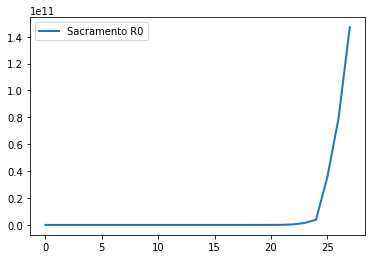

In [39]:
x = range(len(R0_Sacramento))
y1 = R0_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Sacramento R0")
plt.legend()
plt.show()

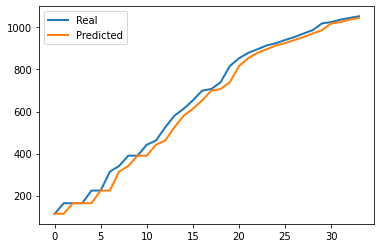

In [40]:
pred_vals = []
for i in range(len(train_past_cases_1d)):
    pred_vals.append(train_vals[i][202].cpu().numpy())

x = range(len(train_past_cases_1d))
y1 = train_labels_Sacramento
y2 = pred_vals
plt.plot(x, y1, ls="-", lw=2, label="Real")
plt.plot(x, y2, ls="-", lw=2, label="Predicted")
plt.legend()
plt.show()

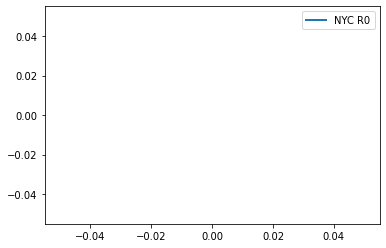

In [41]:
x = range(len(train_past_cases_1d))
y_NYC = R0_NYC
plt.plot(x, y_NYC, ls="-", lw=2, label="NYC R0")
plt.legend()
plt.show()

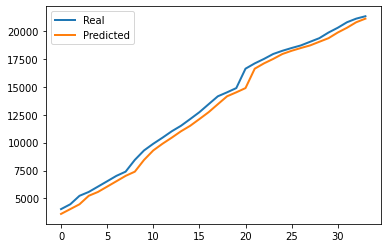

In [42]:
pred_vals_NYC = []
for i in range(len(train_past_cases_1d)):
    pred_vals_NYC.append(train_vals[i][4].cpu().numpy())

x = range(len(train_past_cases_1d))
y1 = train_labels_NYC
y2 = pred_vals_NYC
plt.plot(x, y1, ls="-", lw=2, label="Real")
plt.plot(x, y2, ls="-", lw=2, label="Predicted")
plt.legend()
plt.show()

### GAT - SIR

In [83]:
hidden_size = 100
learning_rate = 0.0000005
num_epochs = 1000
batch_size = 1000
output_size = 2

device = th.device('cuda:0')
input_size = train_past_cases[0].shape[1] + attrs.shape[1]
gat_sir = GAT_SIR(g, input_size, hidden_size, output_size, 1)
print('#features:', input_size)

# Move model to GPU
gat_sir = gat_sir.to(device)
# TODO we might want to choose a better loss.
# L2 loss will penalize the data points with larger deaths more. Is this what we want?
# criterion = criterion.to(device)

# Move data to GPU
pop = pop.to(device)
attrs = attrs.to(device)
for i in range(len(train_past_cases)):
    train_past_cases[i] = train_past_cases[i].to(device)
    train_past_deaths[i] = train_past_deaths[i].to(device)
    train_labels_cases[i] = train_labels_cases[i].to(device)
    train_labels_deaths[i] = train_labels_deaths[i].to(device)
    if len(train_labels_cases[i].shape) == 1:
        train_labels_cases[i] = train_labels_cases[i].unsqueeze(1)
    if len(train_labels_deaths[i].shape) == 1:
        train_labels_deaths[i] = train_labels_deaths[i].unsqueeze(1)
        
for i in range(len(valid_past_cases)):
    valid_past_cases[i] = valid_past_cases[i].to(device)
    valid_past_deaths[i] = valid_past_deaths[i].to(device)
    valid_labels_cases[i] = valid_labels_cases[i].to(device)
    valid_labels_deaths[i] = valid_labels_deaths[i].to(device)
    if len(valid_labels_cases[i].shape) == 1:
         valid_labels_cases[i] = valid_labels_cases[i].unsqueeze(1)
    if len(test_labels_deaths[i].shape) == 1:
        valid_labels_deaths[i] = valid_labels_deaths[i].unsqueeze(1)

for i in range(len(test_past_cases)):
    test_past_cases[i] = test_past_cases[i].to(device)
    test_past_deaths[i] = test_past_deaths[i].to(device)
    test_labels_cases[i] = test_labels_cases[i].to(device)
    test_labels_deaths[i] = test_labels_deaths[i].to(device)
    if len(test_labels_cases[i].shape) == 1:
        test_labels_cases[i] = test_labels_cases[i].unsqueeze(1)
    if len(test_labels_deaths[i].shape) == 1:
        test_labels_deaths[i] = test_labels_deaths[i].unsqueeze(1)
        
# Normalize attrs
attrs[th.isnan(attrs)] = 0
attr_mean = th.mean(attrs, dim=1, keepdim=True)
attrs = attrs - attr_mean
attr_std = th.std(attrs, dim=1, keepdim=True)
attrs = attrs / attr_std

optimizer = th.optim.Adam(gat_sir.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    losses = []
    for idx in range(19, len(train_past_cases)):
        labels_cases = train_labels_cases[idx]
        labels_deaths = train_labels_deaths[idx]
        batch = th.cat([train_past_cases[idx], attrs], dim=1)
        th.manual_seed(1)
        vals = gat_sir(batch)
        I = train_past_cases[idx][:,-1].view(3142,1)
        D = train_past_deaths[idx][:,-1].view(3142,1)
        I_new, D_new = sir_output(vals, I, D)
        loss = my_msle_ID(I_new, D_new, labels_cases, labels_deaths)
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
    
    with th.no_grad():
        eval_errs = []
        test_errs = []
        test_mses = []
        test_maes = []
        for idx in range(6):
            valid_feats = th.cat([valid_past_cases[idx], attrs], dim=1)
            eval_vals = gat_sir(valid_feats)
            eval_I = valid_past_cases[idx][:,-1].view(3142,1)
            eval_D = valid_past_deaths[idx][:,-1].view(3142,1)
            eval_labels_cases = valid_labels_cases[idx]
            eval_labels_deaths = valid_labels_deaths[idx]
            eval_I_new, eval_D_new = sir_output(eval_vals, eval_I, eval_D)
            err = my_msle_ID(eval_I_new, eval_D_new, eval_labels_cases, eval_labels_deaths)
            eval_errs.append(err.cpu().numpy())
            
            
            test_feats = th.cat([test_past_cases[idx], attrs], dim=1)
            test_vals = gat_sir(test_feats)
            test_I = test_past_cases[idx][:,-1].view(3142,1)
            test_D = test_past_deaths[idx][:,-1].view(3142,1)
            test_cases = test_labels_cases[idx]
            test_deaths = test_labels_deaths[idx]
            test_I_new, test_D_new = sir_output(test_vals, test_I, test_D)
            test_err = my_msle_ID(test_I_new, test_D_new, test_cases, test_deaths)
            test_mse = th.mean((test_I_new - test_labels_cases[idx])**2)
            test_mae = th.mean(th.abs(test_I_new - test_labels_cases[idx]))
            test_errs.append(test_err.cpu().numpy())
            test_mses.append(test_mse.cpu().numpy())
            test_maes.append(test_mae.cpu().numpy())
        print('epoch={}, loss={:.3f}, validation loss = {:.3f}, test loss={:.3f}, test mse = {:.3f}, test mae = {:.3f}'.format(epoch, np.mean(losses), np.mean(eval_errs), np.mean(test_errs), np.mean(test_mses), np.mean(test_maes)))
            
#        if np.mean(eval_errs) <= 0.054:
#            R0_NYC = []
#            R0_Sacramento = []
#            gamma_NYC = []
#            beta_NYC = []
#            gamma_Sacramento = []
#            beta_Sacramento = []
#            train_vals = []
#            for idx in range(19, len(train_past_cases)):
#                labels = train_labels_cases[idx]
#                batch = th.cat([train_past_cases[idx], attrs], dim=1)
#                th.manual_seed(1)
#                vals = mlp_sir(batch)
#                gamma_NYC.append(vals[4][0])
#                gamma_Sacramento.append(vals[202][0])
#                beta_NYC.append(vals[4][1])
#                beta_Sacramento.append(vals[202][1])
#                R_NYC_div = th.div(vals[4][1],vals[4][0])
#                R_Sacramento_div = th.div(vals[202][1],vals[202][0])
#                R0_NYC.append(R_NYC_div)
#                R0_Sacramento.append(R_Sacramento_div)  
#                I = train_past_cases[idx][:,-1].view(3142,1)
#                D = train_past_deaths[idx][:,-1].view(3142,1)
#                output = sir_output(vals, I, D, labels)
#                train_vals.append(output)
#            break
#        print('epoch={}, loss={:.3f}, validation loss = {:.3f}, test loss={:.3f}, test mse = {:.3f}, test mae = {:.3f}'.format(epoch, np.mean(losses), np.mean(eval_errs), np.mean(test_errs), np.mean(test_mses), np.mean(test_maes)))

#features: 97


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


epoch=0, loss=1.290, validation loss = 1.034, test loss=1.158, test mse = 2015927.125, test mae = 83.997
epoch=1, loss=1.031, validation loss = 0.541, test loss=0.573, test mse = 30787.713, test mae = 32.163
epoch=2, loss=0.940, validation loss = 0.415, test loss=0.501, test mse = 30350.523, test mae = 30.228
epoch=3, loss=0.886, validation loss = 0.356, test loss=0.482, test mse = 32233.656, test mae = 29.857
epoch=4, loss=0.846, validation loss = 0.320, test loss=0.476, test mse = 31585.117, test mae = 29.550
epoch=5, loss=0.813, validation loss = 0.295, test loss=0.475, test mse = 30804.877, test mae = 29.326
epoch=6, loss=0.786, validation loss = 0.274, test loss=0.476, test mse = 30735.885, test mae = 29.166
epoch=7, loss=0.761, validation loss = 0.260, test loss=0.477, test mse = 30400.367, test mae = 28.986
epoch=8, loss=0.739, validation loss = 0.248, test loss=0.478, test mse = 30253.859, test mae = 28.851
epoch=9, loss=0.719, validation loss = 0.238, test loss=0.479, test mse

epoch=79, loss=0.382, validation loss = 0.174, test loss=0.500, test mse = 30220.656, test mae = 28.406


KeyboardInterrupt: 

In [ ]:
with th.no_grad():
    R0_NYC = []
    R0_Sacramento = []
    gamma_NYC = []
    beta_NYC = []
    gamma_Sacramento = []
    beta_Sacramento = []
    train_vals = []
    for idx in range(19, len(train_past_cases_1d)):
        labels = train_labels_cases_1d[idx]
        batch = th.cat([train_past_cases_1d[idx], attrs], dim=1)
        th.manual_seed(1)
        vals = gat_sir(batch)
        gamma_NYC.append(vals[4][0])
        gamma_Sacramento.append(vals[202][0])
        beta_NYC.append(vals[4][1])
        beta_Sacramento.append(vals[202][1])
        R_NYC_div = th.div(vals[4][1],vals[4][0])
        R_Sacramento_div = th.div(vals[202][1],vals[202][0])
        R0_NYC.append(R_NYC_div)
        R0_Sacramento.append(R_Sacramento_div)  
        I = train_past_cases_1d[idx][:,-1].view(3142,1)
        D = train_past_deaths_1d[idx][:,-1].view(3142,1)
        I_new, D_new = sir_1d_output(vals, I, D)
        train_vals.append(I_new)

In [ ]:
x = range(len(R0_Sacramento))
y1 = R0_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Sacramento R0")
plt.legend()
plt.show()

In [ ]:
pred_vals = []
for i in range(79-19):
    pred_vals.append(train_vals[i][202].cpu().numpy())

x = range(60)
y1 = train_labels_Sacramento
y2 = pred_vals
plt.plot(x, y1, ls="-", lw=2, label="Real")
plt.plot(x, y2, ls="-", lw=2, label="Predicted")
plt.legend()
plt.show()

In [44]:
for i,j,k in zip(beta_Sacramento, gamma_Sacramento, R0_Sacramento):
    print(i, j, k)

tensor(0.0160, device='cuda:0') tensor(0.0062, device='cuda:0') tensor(2.5541, device='cuda:0')
tensor(0.0081, device='cuda:0') tensor(0.0022, device='cuda:0') tensor(3.6677, device='cuda:0')
tensor(0.0038, device='cuda:0') tensor(0.0009, device='cuda:0') tensor(4.3246, device='cuda:0')
tensor(0.0013, device='cuda:0') tensor(0.0002, device='cuda:0') tensor(8.4636, device='cuda:0')
tensor(0.0005, device='cuda:0') tensor(7.1190e-05, device='cuda:0') tensor(7.3065, device='cuda:0')
tensor(0.0002, device='cuda:0') tensor(1.8216e-05, device='cuda:0') tensor(9.7661, device='cuda:0')
tensor(4.8411e-05, device='cuda:0') tensor(2.2408e-06, device='cuda:0') tensor(21.6038, device='cuda:0')
tensor(1.0758e-05, device='cuda:0') tensor(4.2777e-07, device='cuda:0') tensor(25.1499, device='cuda:0')
tensor(1.4434e-06, device='cuda:0') tensor(3.7484e-08, device='cuda:0') tensor(38.5078, device='cuda:0')
tensor(3.8367e-07, device='cuda:0') tensor(5.4012e-09, device='cuda:0') tensor(71.0348, device='cuda:

In [ ]:
x = range(len(R0_NYC))
y_NYC = R0_NYC
plt.plot(x, y_NYC, ls="-", lw=2, label="NYC R0")
plt.legend()
plt.show()

In [ ]:
pred_vals_NYC = []
for i in range(79-19):
    pred_vals_NYC.append(train_vals[i][4].cpu().numpy())

x = range(60)
y1 = train_labels_NYC
y2 = pred_vals_NYC
plt.plot(x, y1, ls="-", lw=2, label="Real")
plt.plot(x, y2, ls="-", lw=2, label="Predicted")
plt.legend()
plt.show()

In [43]:
for i,j,k in zip(beta_NYC, gamma_NYC, R0_NYC):
    print(i, j, k)

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(nan, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(nan, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(nan, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(nan, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(nan, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(nan, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(nan, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(nan, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(nan, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(nan, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(nan, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(na